# This notebook includes the code for tuning the enhanced model

The code of the different iterations of the tuning is not in perfect order, considering tuning ideas were split among group members and investigated at the same time. For the correct tuning timeline, considerations, and results, see the report.

The best enhanced model can be found under section 4.15. Further tuning of the best enhanced model (e.g. effect of zero-padding) can be found in order under the mentioned section.

# 1. Import libraries

In [1]:
# Import necessary libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from google.colab import drive
import numpy as np

# From here, add any libraries that you might need for the rest of your code
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
print(keras.__version__)
print(tf.__version__)

3.5.0
2.17.0


# 2. Load and pre-process the dataset

In [2]:
# drive.mount('/content/drive')

In [3]:
# Set the paths based on your Drive directory
data_dir = r'D:\Documents\Master_Data_Science\Deep Learning\group_assignment\brain_mri_dataset' # Change to the path to your directory
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: D:\Documents\Master_Data_Science\Deep Learning\group_assignment\brain_mri_dataset
Training directory: D:\Documents\Master_Data_Science\Deep Learning\group_assignment\brain_mri_dataset\Training
Testing directory: D:\Documents\Master_Data_Science\Deep Learning\group_assignment\brain_mri_dataset\Testing


In [4]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# Load and preprocess the data
np.random.seed(seed=42)
def add_noise(img):
    std_coeff = 70*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

image_res = 30
def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    # Load training data
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        color_mode='grayscale'
    )

    # Load test data
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        color_mode='grayscale'
    )

    return train_data, test_data

# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## 2.1 Splitting off validation set

In [5]:
# splitting validation set from train_data
# extract images and labels from train_data
class_indices = train_data.class_indices
images = []
labels = []

for i in range(len(train_data)):
    img, lbl = train_data[i]
    images.append(img)
    labels.append(lbl)

# concatenate lists to numpy arrays
images = np.concatenate(images, axis=0)
labels = np.concatenate(labels, axis=0)

# split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.25, random_state=42)

# create ImageDataGenerator instances
datagen = ImageDataGenerator()

# create new iterators for training and validation sets
train_data = datagen.flow(train_images, train_labels, batch_size=32, shuffle=True)
val_data = datagen.flow(val_images, val_labels, batch_size=32, shuffle=False)

# store class_indices and labels in the new iterators
train_data.class_indices = class_indices
train_data.labels = train_labels

val_data.class_indices = class_indices
val_data.labels = val_labels

# sanity check for train_data
for images, labels in train_data:
    print(f"Processed image shape: {images.shape}")
    print(f"Label shape: {labels.shape}") # labels are already one-hot encoded
    break

# sanity check for val_data
for images, labels in val_data:
    print(f"Processed image shape: {images.shape}")
    print(f"Label shape: {labels.shape}") # labels are already one-hot encoded
    break 

Processed image shape: (32, 30, 30, 1)
Label shape: (32, 4)
Processed image shape: (32, 30, 30, 1)
Label shape: (32, 4)


In [6]:
print(f'Number of training samples: {train_data.n}')
print(f'Number of validation samples: {val_data.n}')
print(f'Number of test samples: {test_data.n}')

Number of training samples: 4284
Number of validation samples: 1428
Number of test samples: 1311


# 3. Train and Evaluation functions

In [7]:
def plot_training_curves(history):
    """
    Plot training and validation loss and accuracy curves.
    Args:
        history: history object from model.fit.
    """
    plt.figure(figsize=(12, 6))

    # plot training and validation loss
    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # plot training and validation accuracy
    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
def plot_roc_curve(y_pred, data):
    """
    Plot ROC curve for the model predictions.
    Args:
        y_pred: model predictions as probabilities.
        data: data containing the true labels.
    """
    y_true = data.labels # obtain the true labels from the data
    if len(y_true.shape) == 1: # if the labels are not onehot encoded
        y_true = to_categorical(y_true, num_classes=np.unique(y_true).size) # onehot encode the labels

    # retrieve class names
    classes = list(data.class_indices.keys())

    n_classes = y_true.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    colors = cm.get_cmap('tab20', n_classes)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [9]:
def get_evaluation_metrics(y_pred, data):
    """
    Get evaluation metrics for the model predictions.
    Args:
        y_pred: model predictions as probabilities.
        data: data containing the true labels.
    Returns:
        A dictionary containing the evaluation metrics.
    """
    # convert predicted probabilities to predicted class labels
    y_pred = np.argmax(y_pred, axis=1)

    y_true = data.labels # obtain the true labels from the data
    # ensure y_true is not onehot encoded
    if len(y_true.shape) > 1:
        y_true = np.argmax(y_true, axis=1)

    # retrieve class names
    classes = list(data.class_indices.keys())

    # f1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    # classification report
    print(f'f1 score: {f1}')
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=classes))

    return


In [10]:
def plot_confusion_matrix(y_pred, data):
    """
    Plot confusion matrix for the model predictions.
    Args:
        y_pred: model predictions as probabilities.
        data: data containing the true labels.
    """
    y_true = data.labels
    # ensure y_true is in integer format
    if len(y_true.shape) > 1:
        y_true = np.argmax(y_true, axis=1)

    # retrieve class names
    classes = list(data.class_indices.keys())

    # get the predictions from the probabilities
    y_pred = np.argmax(y_pred, axis=1)

    # compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # plot the confusion matrix
    ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap='Blues', values_format='d', colorbar=True)

# 4. Enhanced model tuning

## 4.1 - Increasing complexity for ability to learn more representations (Additional conv layers, filters)
Also adds zero-padding to reduce loss of information, and batch normalization

In [11]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= images.shape[1:], padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu',padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))  

    return model


# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Train the model
history6 = model.fit(train_data, epochs=10, batch_size=32 ,
                    validation_data=(val_data), verbose=1)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,366,692 (5.21 MB)

 Trainable params: 1,364,964 (5.21 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/10
  2/134 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.3672 - loss: 2.3136

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.6169 - loss: 1.0815 - val_accuracy: 0.2920 - val_loss: 2.2393
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.7632 - loss: 0.5659 - val_accuracy: 0.4118 - val_loss: 3.3257
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8442 - loss: 0.3971 - val_accuracy: 0.5357 - val_loss: 1.7337
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8837 - loss: 0.2927 - val_accuracy: 0.7206 - val_loss: 0.7253
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.8944 - loss: 0.2570 - val_accuracy: 0.7857 - val_loss: 0.5978
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9316 - loss: 0.1666 - val_accuracy: 0.7430 - val_loss: 0.8822
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.9503 - loss: 0.1368 - val_accuracy: 0.8053 - val_loss: 0.6549
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.9581 - loss: 0.1015 - val_accuracy: 0.62

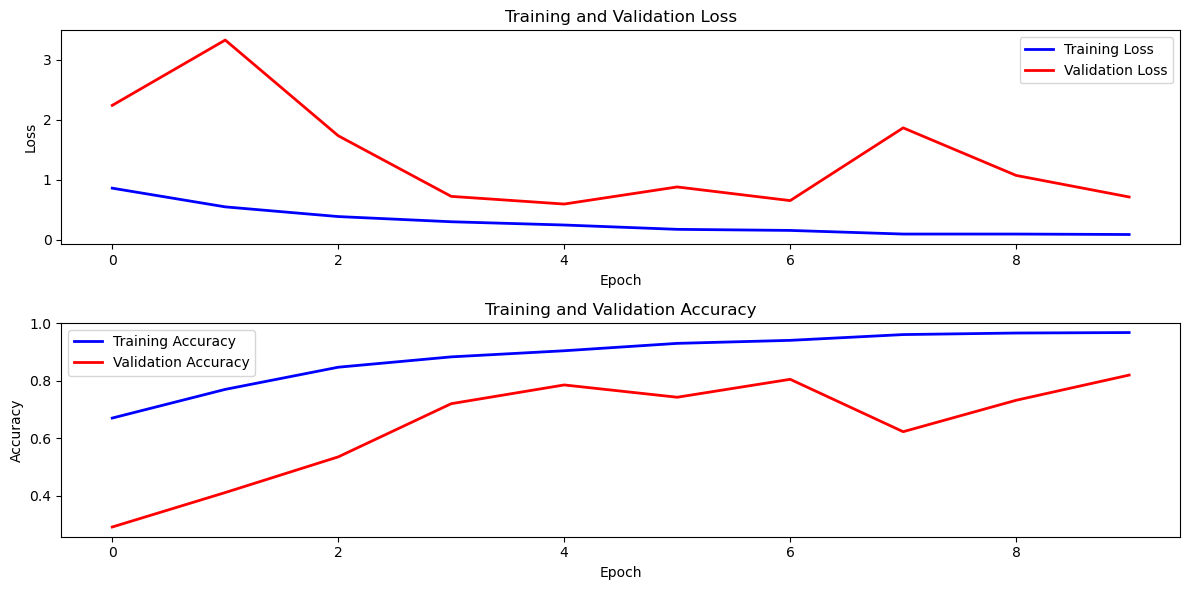

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


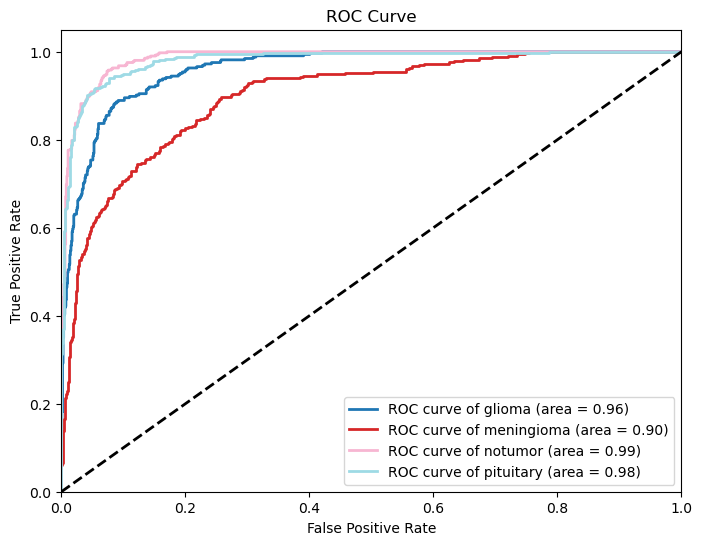

f1 score: 0.8177916693226038
Classification Report:
              precision    recall  f1-score   support

      glioma       0.84      0.72      0.77       325
  meningioma       0.70      0.69      0.69       333
     notumor       0.84      0.95      0.89       407
   pituitary       0.89      0.88      0.89       363

    accuracy                           0.82      1428
   macro avg       0.82      0.81      0.81      1428
weighted avg       0.82      0.82      0.82      1428



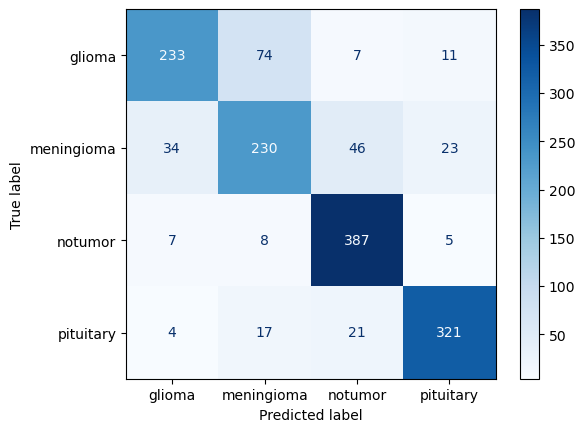

In [12]:
# plot the training curves 
plot_training_curves(history6)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.2 - Nadam optimizer & more dense layers

In [13]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Nadam  # Import Nadam optimizer

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=images.shape[1:], padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))  

    return model

# Instantiate the model
model = enhanced()

# Compile the model using Nadam optimizer
model.compile(optimizer=Nadam(),
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Train the model
history15 = model.fit(train_data, epochs=12, batch_size=64,
                    validation_data=val_data, verbose=1)



c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,426,740 (5.44 MB)

 Trainable params: 1,425,012 (5.44 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.5771 - loss: 1.0187 - val_accuracy: 0.2850 - val_loss: 1.5976
Epoch 2/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.7828 - loss: 0.5394 - val_accuracy: 0.2808 - val_loss: 2.0431
Epoch 3/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8388 - loss: 0.4039 - val_accuracy: 0.5833 - val_loss: 1.3791
Epoch 4/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.8800 - loss: 0.3049 - val_accuracy: 0.7346 - val_loss: 0.7489
Epoch 5/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9253 - loss: 0.2062 - val_accuracy: 0.7577 - val_loss: 0.6839
Epoch 6/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9433 - loss: 0.1502 - val_accuracy: 0.7808 - val_loss: 0.6049
Epoch 7/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9390 - loss: 0.1592 - val_accuracy: 0.8137 - val_loss: 0.6845
Epoch 8/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9686 - loss: 0.0868 - val_acc

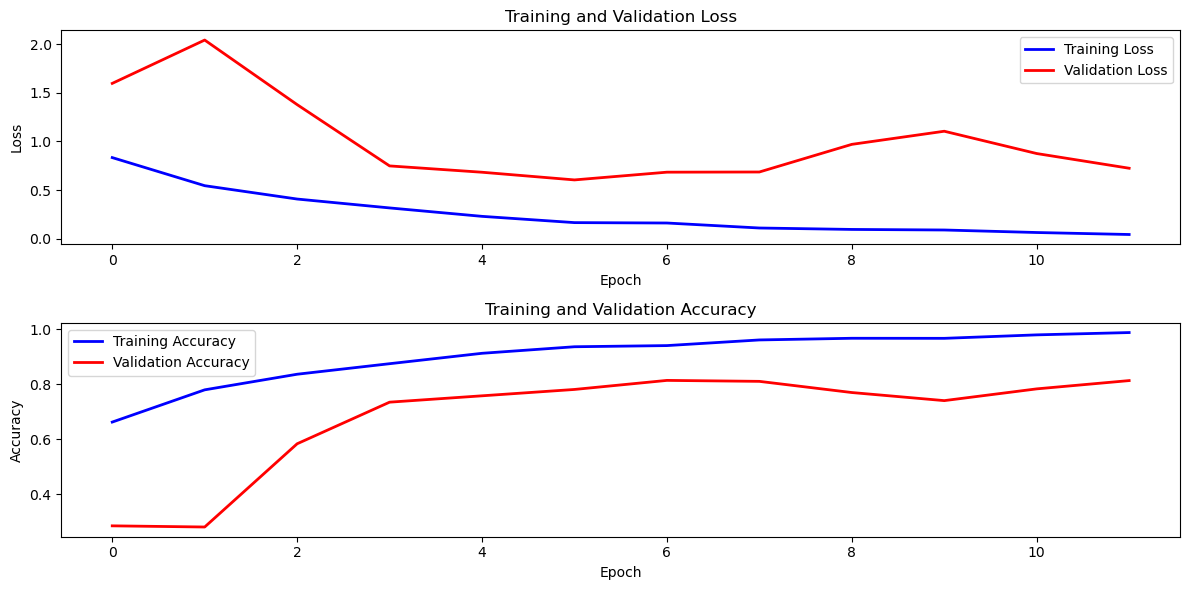

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


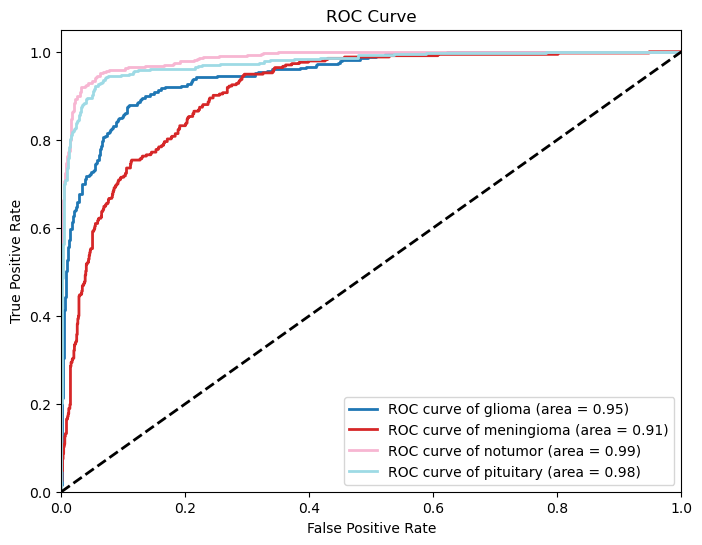

f1 score: 0.8177685911057897
Classification Report:
              precision    recall  f1-score   support

      glioma       0.78      0.79      0.78       325
  meningioma       0.63      0.76      0.69       333
     notumor       0.96      0.84      0.89       407
   pituitary       0.90      0.86      0.88       363

    accuracy                           0.81      1428
   macro avg       0.82      0.81      0.81      1428
weighted avg       0.83      0.81      0.82      1428



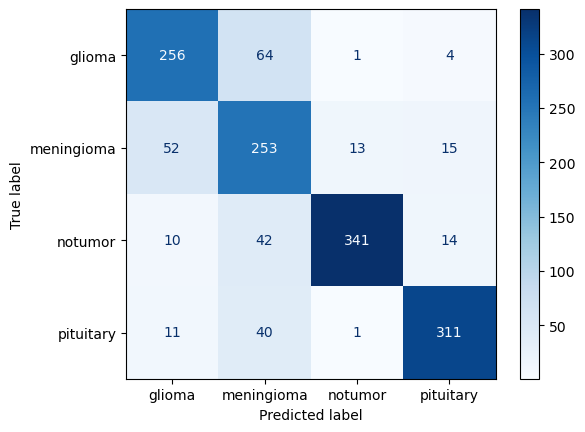

In [14]:
# plot the training curves 
plot_training_curves(history15)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.3- L2 regularization

In [15]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras import regularizers

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01),  # L2 regularization
                            input_shape=images.shape[1:], padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01),  # L2 regularization
                            padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01),  # L2 regularization
                            padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(512, (3, 3), activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01),  # L2 regularization
                            padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers with L2 regularization
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', 
                           kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization
    model.add(layers.Dense(64, activation='relu', 
                           kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization
    model.add(layers.Dense(32, activation='relu', 
                           kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization
    model.add(layers.Dense(16, activation='relu', 
                           kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization
    model.add(layers.Dense(4, activation='softmax'))  

    return model

# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Train the model
history14 = model.fit(train_data, epochs=12, batch_size=64,
                    validation_data=val_data, verbose=1)


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,426,740 (5.44 MB)

 Trainable params: 1,425,012 (5.44 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.5318 - loss: 7.7584 - val_accuracy: 0.2276 - val_loss: 4.2609
Epoch 2/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.7647 - loss: 2.8490 - val_accuracy: 0.2577 - val_loss: 2.8339
Epoch 3/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.7699 - loss: 1.8429 - val_accuracy: 0.4090 - val_loss: 2.4295
Epoch 4/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.8040 - loss: 1.4337 - val_accuracy: 0.6289 - val_loss: 1.7206
Epoch 5/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.8358 - loss: 1.2553 - val_accuracy: 0.6793 - val_loss: 1.5490
Epoch 6/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.8436 - loss: 1.1501 - val_accuracy: 0.7276 - val_loss: 1.4057
Epoch 7/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.8554 - loss: 1.1054 - val_accuracy: 0.6646 - val_loss: 1.5158
Epoch 8/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8786 - loss: 1.0413 - val_acc

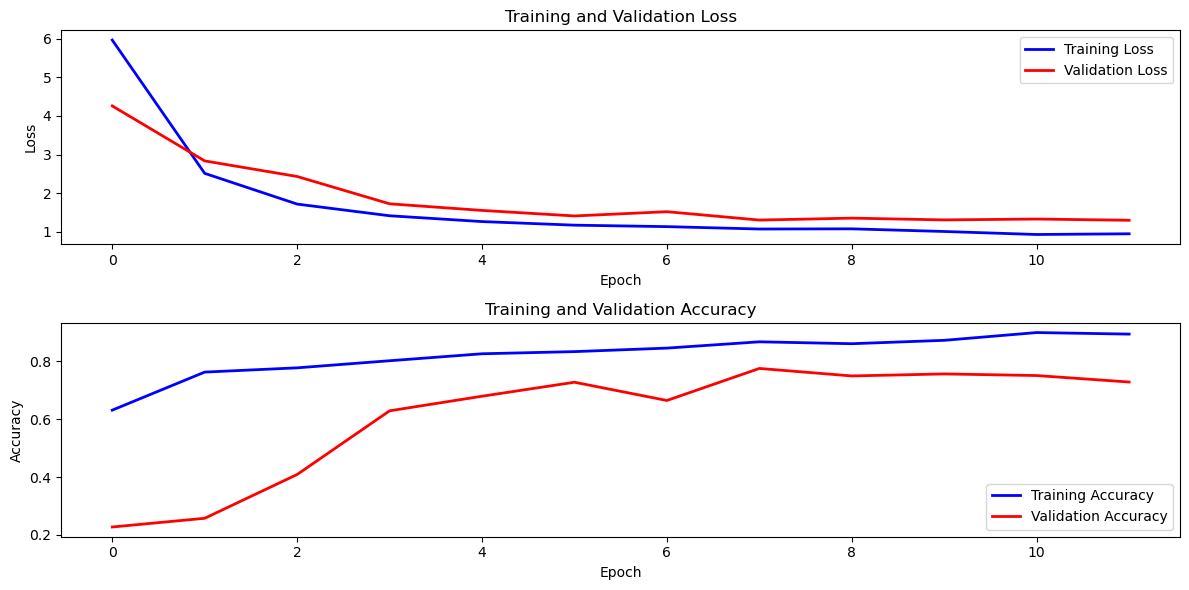

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


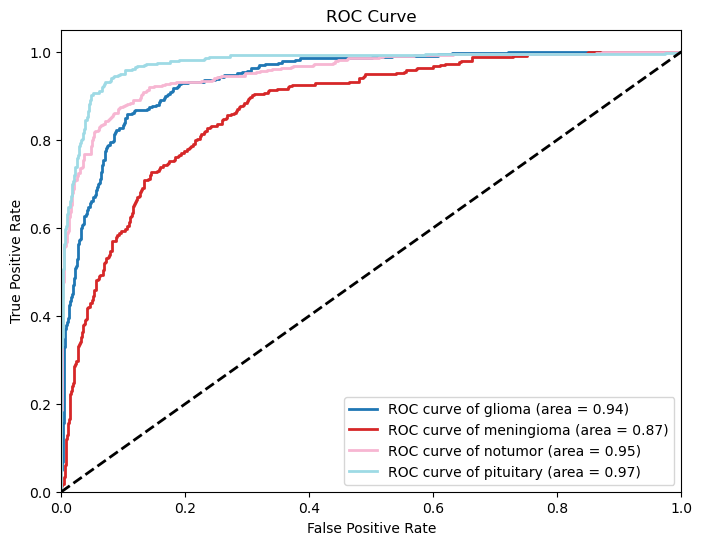

f1 score: 0.7282057541815722
Classification Report:
              precision    recall  f1-score   support

      glioma       0.88      0.47      0.61       325
  meningioma       0.52      0.83      0.64       333
     notumor       0.88      0.70      0.78       407
   pituitary       0.82      0.91      0.87       363

    accuracy                           0.73      1428
   macro avg       0.77      0.72      0.72      1428
weighted avg       0.78      0.73      0.73      1428



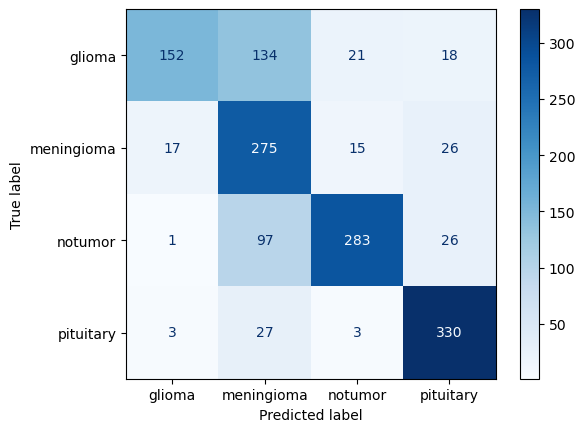

In [16]:
# plot the training curves 
plot_training_curves(history14)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.4 - increased epochs & early stopping & more dense layers

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=images.shape[1:], padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))  

    return model

# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               restore_best_weights=True)

# Train the model with increased epochs and early stopping
history13 = model.fit(train_data, epochs=30,  # Increased number of epochs
                    batch_size=64,
                    validation_data=val_data,
                    callbacks=[early_stopping],  # Adding early stopping
                    verbose=1)


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,426,740 (5.44 MB)

 Trainable params: 1,425,012 (5.44 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.4977 - loss: 1.1534 - val_accuracy: 0.2493 - val_loss: 1.5428
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.7661 - loss: 0.6097 - val_accuracy: 0.2927 - val_loss: 2.2252
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8259 - loss: 0.4501 - val_accuracy: 0.5707 - val_loss: 1.1770
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.8731 - loss: 0.3254 - val_accuracy: 0.6884 - val_loss: 0.8033
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8927 - loss: 0.2778 - val_accuracy: 0.6527 - val_loss: 1.2082
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9312 - loss: 0.2010 - val_accuracy: 0.7773 - val_loss: 0.7291
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.9333 - loss: 0.1892 - val_accuracy: 0.7703 - val_loss: 0.7692
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9674 - loss: 0.0918 - val_acc

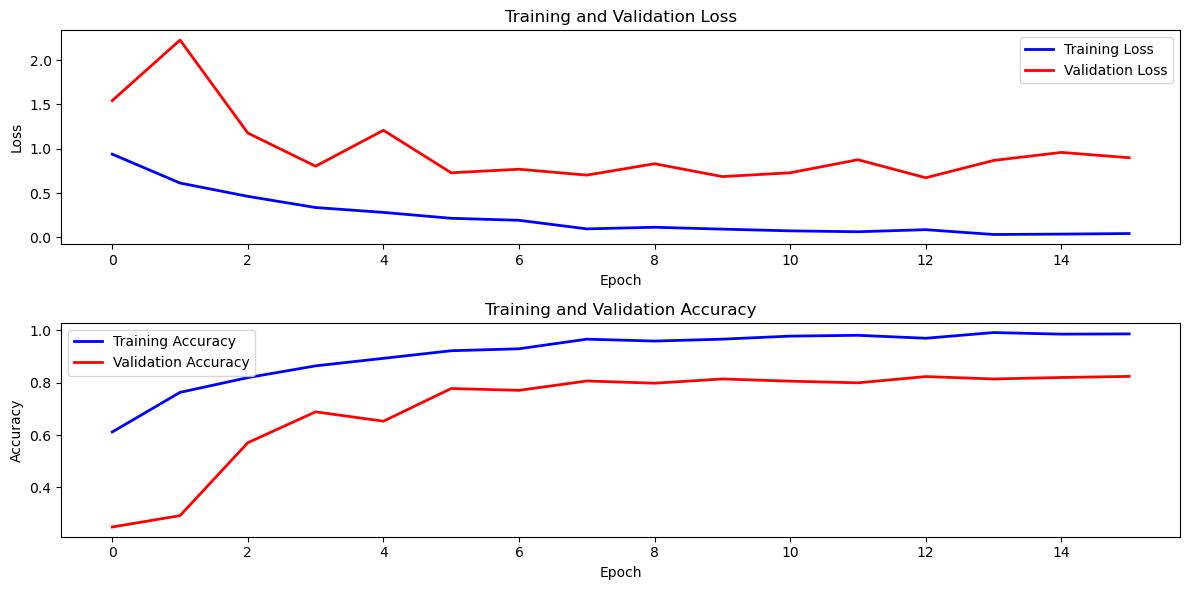

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


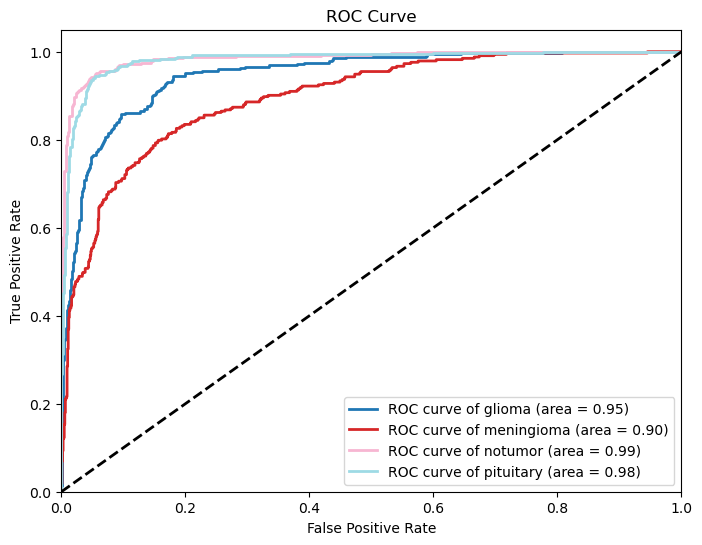

f1 score: 0.8250151079214311
Classification Report:
              precision    recall  f1-score   support

      glioma       0.74      0.82      0.78       325
  meningioma       0.69      0.71      0.70       333
     notumor       0.95      0.87      0.91       407
   pituitary       0.90      0.87      0.89       363

    accuracy                           0.82      1428
   macro avg       0.82      0.82      0.82      1428
weighted avg       0.83      0.82      0.83      1428



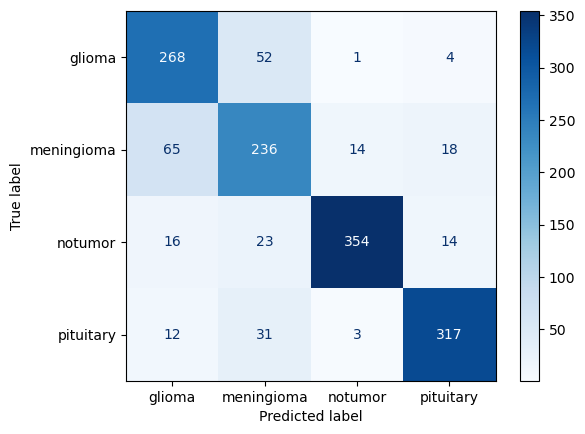

In [18]:
# plot the training curves 
plot_training_curves(history13)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.5 - Leaky ReLu

In [19]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization, LeakyReLU

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=images.shape[1:]))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.Dense(64))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.Dense(32))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.Dense(16))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.Dense(4, activation='softmax'))  

    return model

# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Train the model
history12 = model.fit(train_data, epochs=12, batch_size=64,
                    validation_data=val_data, verbose=1)


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 7, 7, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32)             │             

 Total params: 1,426,740 (5.44 MB)

 Trainable params: 1,425,012 (5.44 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.5519 - loss: 1.0557 - val_accuracy: 0.2542 - val_loss: 2.8904
Epoch 2/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.7565 - loss: 0.6057 - val_accuracy: 0.3018 - val_loss: 2.3560
Epoch 3/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8297 - loss: 0.4338 - val_accuracy: 0.6120 - val_loss: 1.3221
Epoch 4/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.8675 - loss: 0.3457 - val_accuracy: 0.7395 - val_loss: 0.7969
Epoch 5/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.9208 - loss: 0.2064 - val_accuracy: 0.7052 - val_loss: 0.7917
Epoch 6/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9468 - loss: 0.1493 - val_accuracy: 0.7549 - val_loss: 0.8010
Epoch 7/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.9463 - loss: 0.1586 - val_accuracy: 0.8165 - val_loss: 0.6465
Epoch 8/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9741 - loss: 0.0753 - val_acc

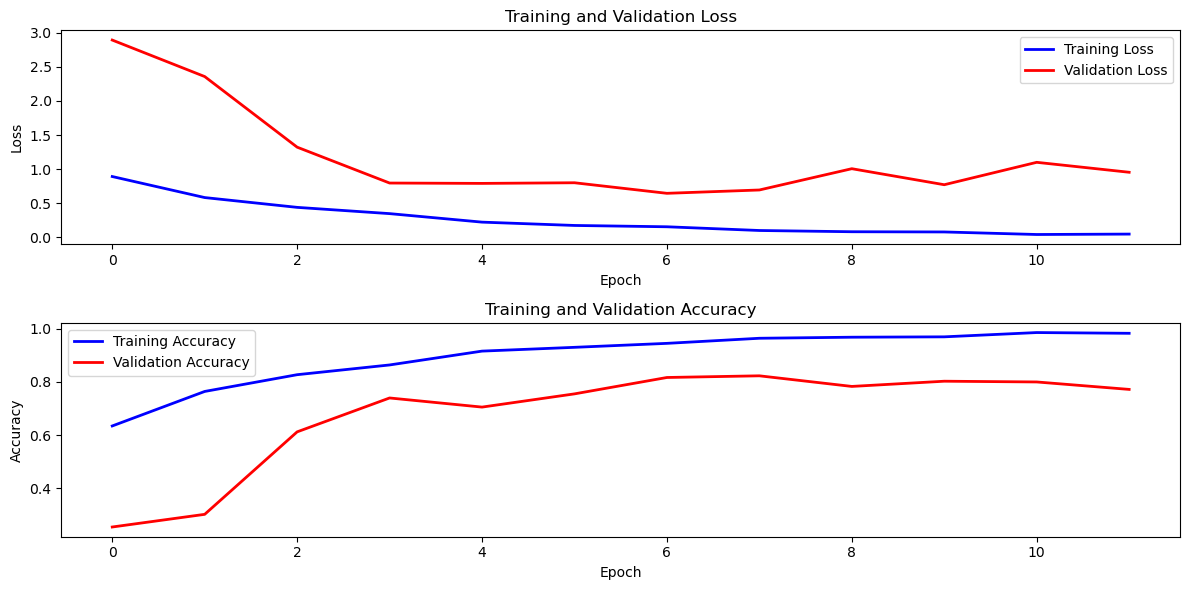

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


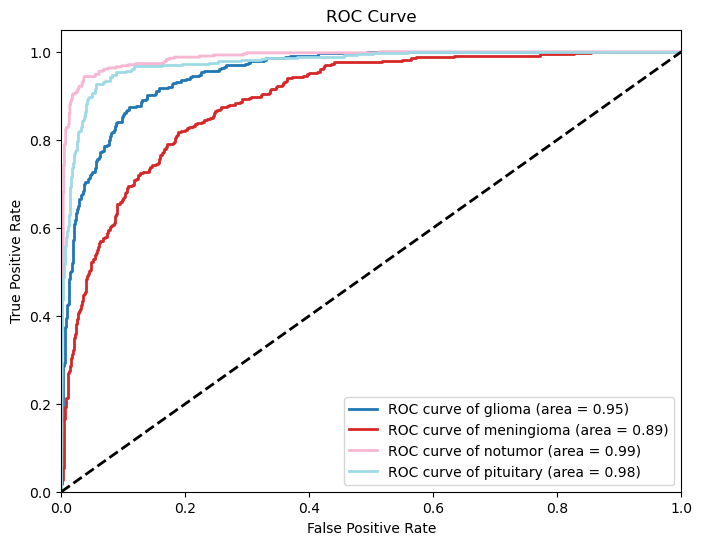

f1 score: 0.7607491460627789
Classification Report:
              precision    recall  f1-score   support

      glioma       0.71      0.84      0.77       325
  meningioma       0.78      0.46      0.57       333
     notumor       0.73      0.97      0.83       407
   pituitary       0.92      0.77      0.84       363

    accuracy                           0.77      1428
   macro avg       0.78      0.76      0.76      1428
weighted avg       0.78      0.77      0.76      1428



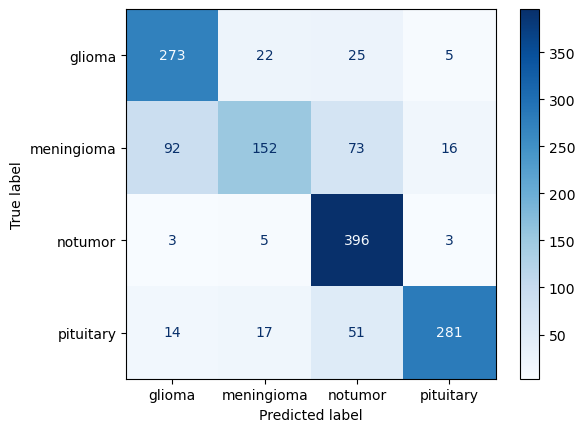

In [20]:
# plot the training curves 
plot_training_curves(history12)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.6 - Higher batch size & more dense layers

In [21]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=images.shape[1:], padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))  

    return model

# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Train the model
history11 = model.fit(train_data, epochs=12, batch_size=64,
                    validation_data=val_data, verbose=1)


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 7, 7, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,426,740 (5.44 MB)

 Trainable params: 1,425,012 (5.44 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.5699 - loss: 1.0030 - val_accuracy: 0.2542 - val_loss: 2.5565
Epoch 2/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.7792 - loss: 0.5615 - val_accuracy: 0.4293 - val_loss: 1.4546
Epoch 3/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8149 - loss: 0.4568 - val_accuracy: 0.6268 - val_loss: 1.1657
Epoch 4/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.8602 - loss: 0.3532 - val_accuracy: 0.6989 - val_loss: 0.8313
Epoch 5/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8840 - loss: 0.2992 - val_accuracy: 0.7017 - val_loss: 0.9894
Epoch 6/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.9299 - loss: 0.1911 - val_accuracy: 0.7850 - val_loss: 0.6258
Epoch 7/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9546 - loss: 0.1450 - val_accuracy: 0.7780 - val_loss: 0.7457
Epoch 8/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.9463 - loss: 0.1432 - val_acc

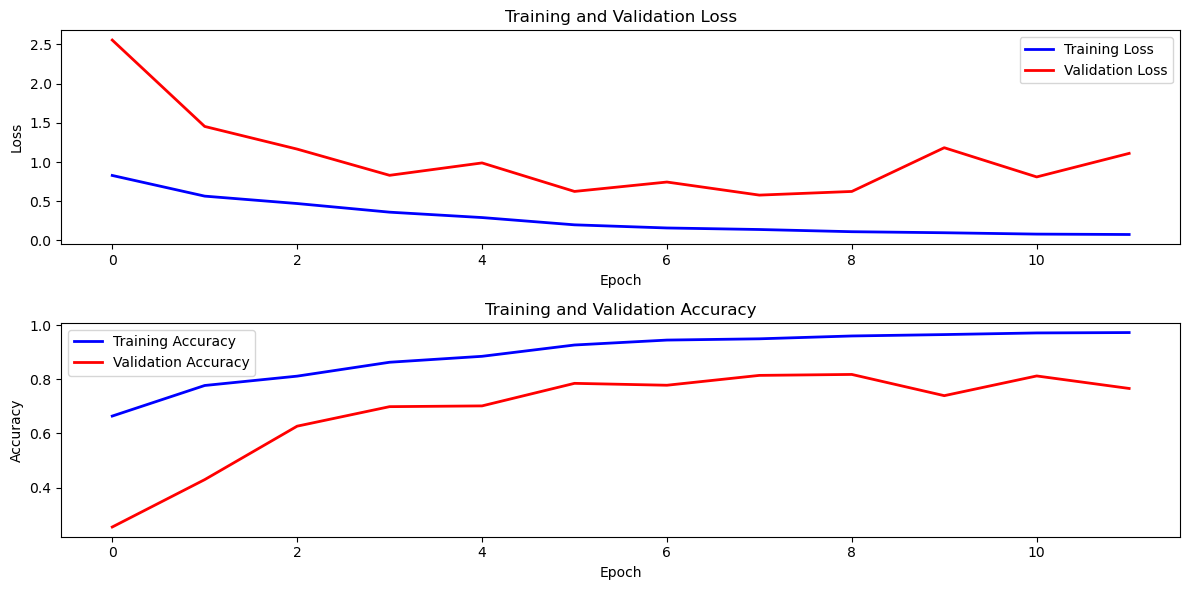

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


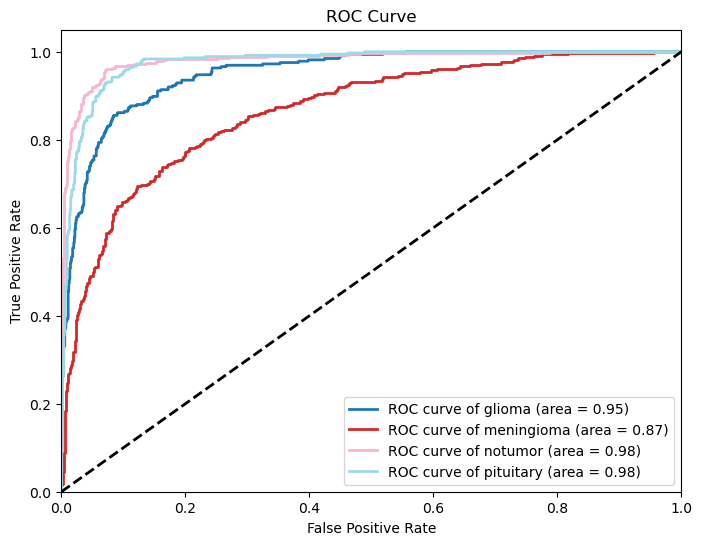

f1 score: 0.7527416030358839
Classification Report:
              precision    recall  f1-score   support

      glioma       0.58      0.94      0.72       325
  meningioma       0.83      0.36      0.50       333
     notumor       0.93      0.85      0.89       407
   pituitary       0.84      0.89      0.86       363

    accuracy                           0.77      1428
   macro avg       0.79      0.76      0.74      1428
weighted avg       0.80      0.77      0.75      1428



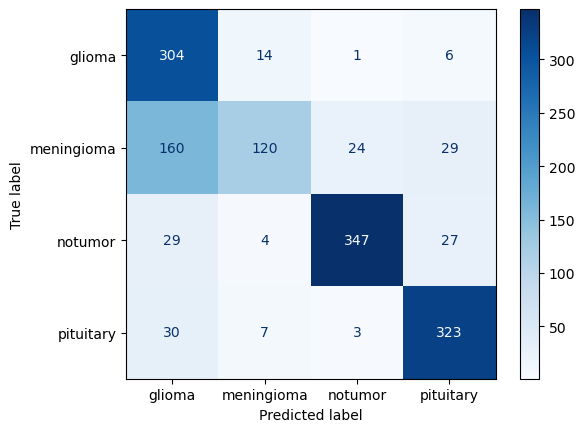

In [22]:
# plot the training curves 
plot_training_curves(history11)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.7 - Leaky Relu and higher batch size

In [23]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization, LeakyReLU

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=images.shape[1:]))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))  

    return model

# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Train the model
history9 = model.fit(train_data, epochs=16, batch_size=128,
                    validation_data=val_data, verbose=1)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 7, 7, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,366,692 (5.21 MB)

 Trainable params: 1,364,964 (5.21 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/16
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.6031 - loss: 1.1529 - val_accuracy: 0.2542 - val_loss: 4.5324
Epoch 2/16
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.7868 - loss: 0.5340 - val_accuracy: 0.4048 - val_loss: 1.4829
Epoch 3/16
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.8433 - loss: 0.3867 - val_accuracy: 0.5070 - val_loss: 1.5394
Epoch 4/16
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.8964 - loss: 0.2468 - val_accuracy: 0.6415 - val_loss: 1.1498
Epoch 5/16
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9274 - loss: 0.1965 - val_accuracy: 0.8060 - val_loss: 0.5588
Epoch 6/16
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.9596 - loss: 0.1125 - val_accuracy: 0.8004 - val_loss: 0.6527
Epoch 7/16
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9757 - loss: 0.0753 - val_accuracy: 0.6667 - val_loss: 1.3740
Epoch 8/16
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.9597 - loss: 0.1253 - val_acc

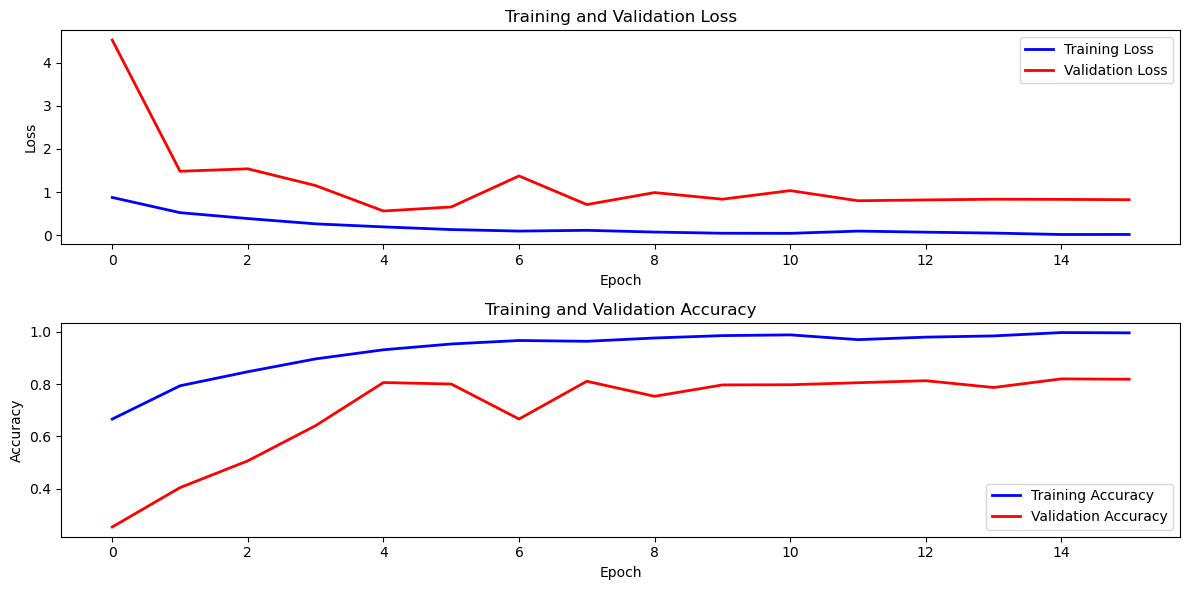

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


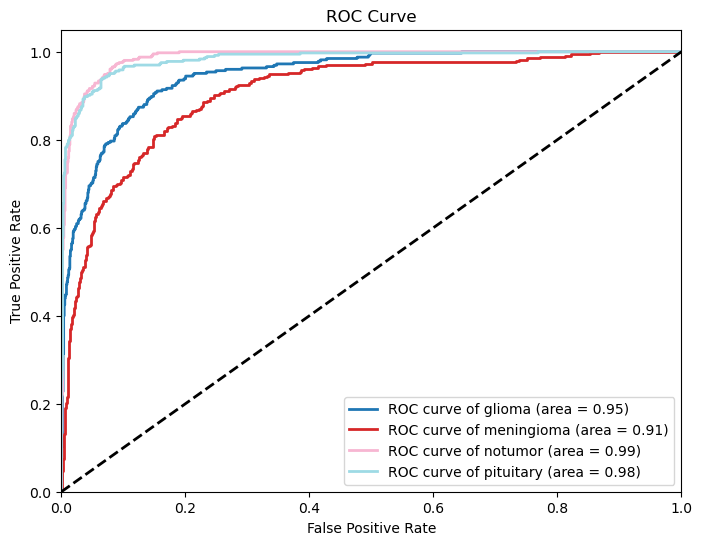

f1 score: 0.8170398552088851
Classification Report:
              precision    recall  f1-score   support

      glioma       0.76      0.79      0.77       325
  meningioma       0.74      0.66      0.70       333
     notumor       0.92      0.88      0.90       407
   pituitary       0.83      0.92      0.87       363

    accuracy                           0.82      1428
   macro avg       0.81      0.81      0.81      1428
weighted avg       0.82      0.82      0.82      1428



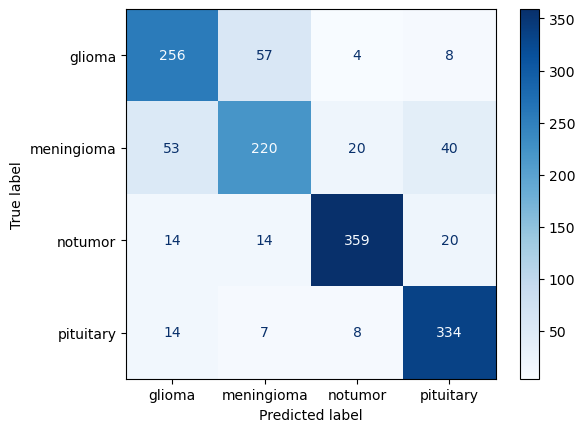

In [24]:
# plot the training curves 
plot_training_curves(history9)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.8 - higher batch size

In [25]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= images.shape[1:], padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu',padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))  

    return model


# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Train the model
history8 = model.fit(train_data, epochs=12, batch_size=64 ,
                    validation_data=(val_data), verbose=1)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 7, 7, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,366,692 (5.21 MB)

 Trainable params: 1,364,964 (5.21 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.5778 - loss: 1.2512 - val_accuracy: 0.2850 - val_loss: 2.1232
Epoch 2/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.7887 - loss: 0.5404 - val_accuracy: 0.2773 - val_loss: 1.9675
Epoch 3/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.8350 - loss: 0.4115 - val_accuracy: 0.4209 - val_loss: 2.3770
Epoch 4/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9023 - loss: 0.2547 - val_accuracy: 0.6050 - val_loss: 1.1892
Epoch 5/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9281 - loss: 0.1952 - val_accuracy: 0.7227 - val_loss: 0.8789
Epoch 6/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9523 - loss: 0.1309 - val_accuracy: 0.7290 - val_loss: 0.8514
Epoch 7/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9669 - loss: 0.0952 - val_accuracy: 0.8312 - val_loss: 0.5614
Epoch 8/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9756 - loss: 0.0738 - val_acc

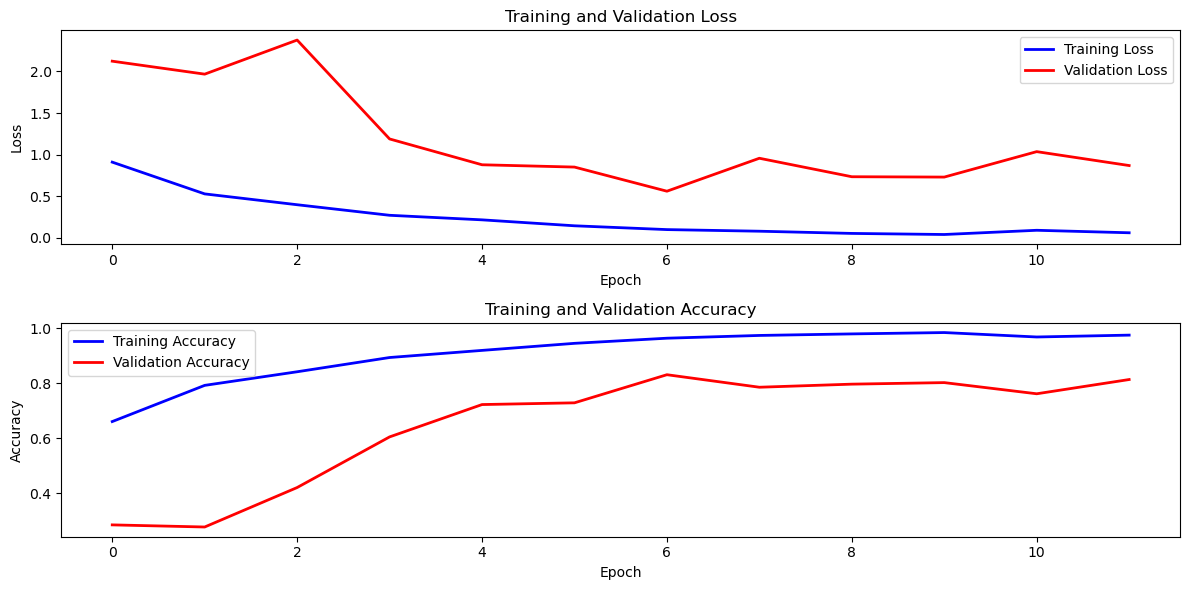

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


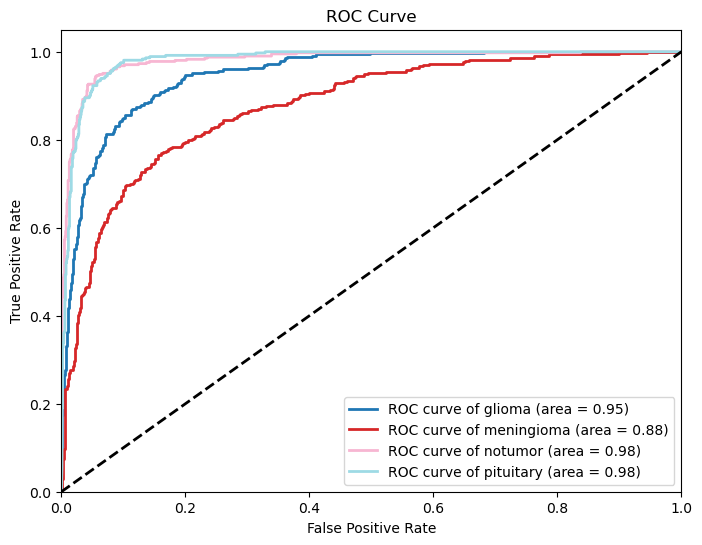

f1 score: 0.8048825592207184
Classification Report:
              precision    recall  f1-score   support

      glioma       0.76      0.81      0.79       325
  meningioma       0.76      0.52      0.62       333
     notumor       0.89      0.93      0.91       407
   pituitary       0.81      0.96      0.88       363

    accuracy                           0.81      1428
   macro avg       0.81      0.80      0.80      1428
weighted avg       0.81      0.81      0.80      1428



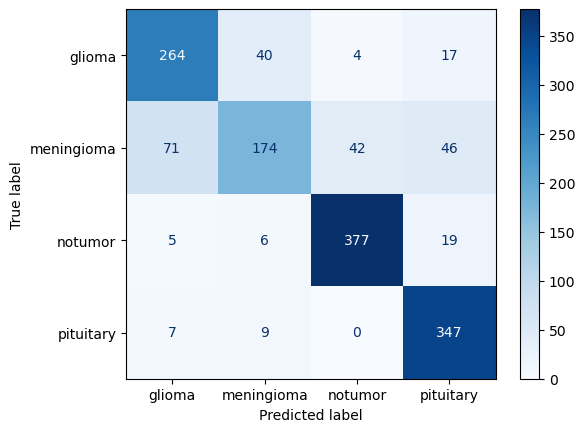

In [26]:
# plot the training curves 
plot_training_curves(history8)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.9 - leaky relu & higher batch size 64

In [27]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization, LeakyReLU

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=images.shape[1:]))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))  

    return model

# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Train the model
history10 = model.fit(train_data, epochs=12, batch_size=64,
                    validation_data=val_data, verbose=1)


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 7, 7, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,366,692 (5.21 MB)

 Trainable params: 1,364,964 (5.21 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.5875 - loss: 1.2861 - val_accuracy: 0.2542 - val_loss: 3.0758
Epoch 2/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.7647 - loss: 0.6058 - val_accuracy: 0.2556 - val_loss: 6.9102
Epoch 3/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.8706 - loss: 0.3437 - val_accuracy: 0.4174 - val_loss: 3.8800
Epoch 4/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9245 - loss: 0.2097 - val_accuracy: 0.6590 - val_loss: 1.1727
Epoch 5/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9503 - loss: 0.1353 - val_accuracy: 0.7668 - val_loss: 0.7599
Epoch 6/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9608 - loss: 0.1123 - val_accuracy: 0.7941 - val_loss: 0.7436
Epoch 7/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.9713 - loss: 0.0824 - val_accuracy: 0.7787 - val_loss: 0.8476
Epoch 8/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9777 - loss: 0.0555 - val_acc

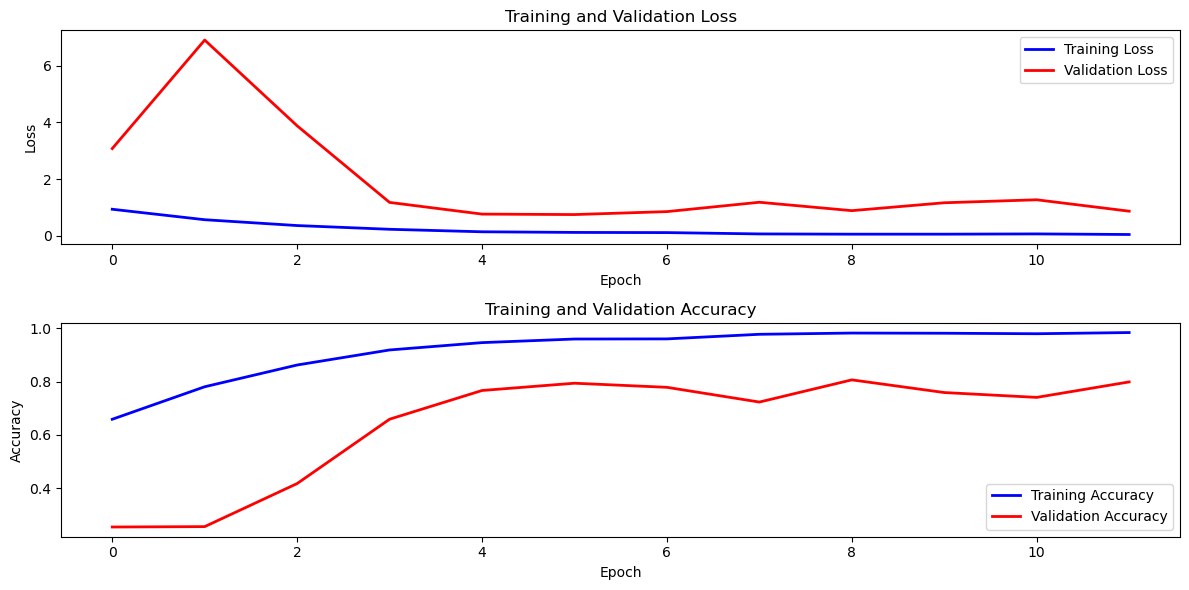

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


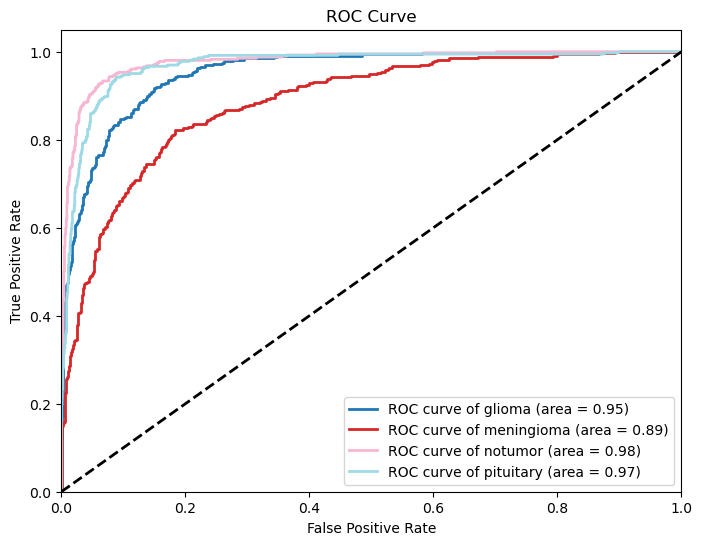

f1 score: 0.7944717830751035
Classification Report:
              precision    recall  f1-score   support

      glioma       0.82      0.70      0.76       325
  meningioma       0.71      0.63      0.67       333
     notumor       0.82      0.95      0.88       407
   pituitary       0.83      0.88      0.85       363

    accuracy                           0.80      1428
   macro avg       0.79      0.79      0.79      1428
weighted avg       0.80      0.80      0.79      1428



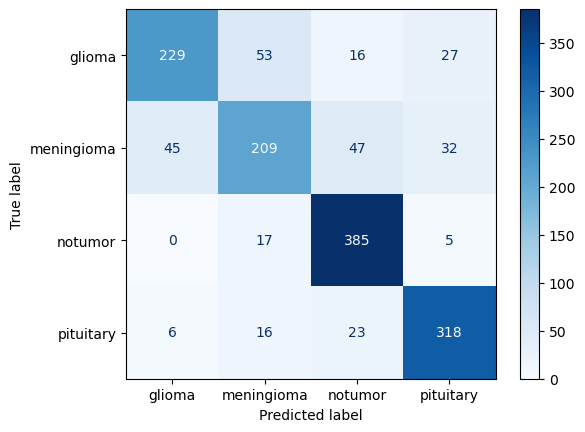

In [28]:
# plot the training curves 
plot_training_curves(history10)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.10 - Leaky relu & normal batch size

In [29]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization, LeakyReLU

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=images.shape[1:]))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))  # Apply Leaky ReLU activation
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))  

    return model

# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Train the model
history7 = model.fit(train_data, epochs=12, batch_size=32,
                    validation_data=val_data, verbose=1)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 7, 7, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,366,692 (5.21 MB)

 Trainable params: 1,364,964 (5.21 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.5915 - loss: 1.3008 - val_accuracy: 0.2542 - val_loss: 3.3303
Epoch 2/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.7849 - loss: 0.5461 - val_accuracy: 0.2626 - val_loss: 3.2217
Epoch 3/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.8601 - loss: 0.3703 - val_accuracy: 0.5035 - val_loss: 2.2979
Epoch 4/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9023 - loss: 0.2571 - val_accuracy: 0.6716 - val_loss: 1.2913
Epoch 5/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.9342 - loss: 0.1656 - val_accuracy: 0.7570 - val_loss: 0.7746
Epoch 6/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9605 - loss: 0.1203 - val_accuracy: 0.7969 - val_loss: 0.6804
Epoch 7/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9700 - loss: 0.0839 - val_accuracy: 0.7920 - val_loss: 0.7556
Epoch 8/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9756 - loss: 0.0664 - val_acc

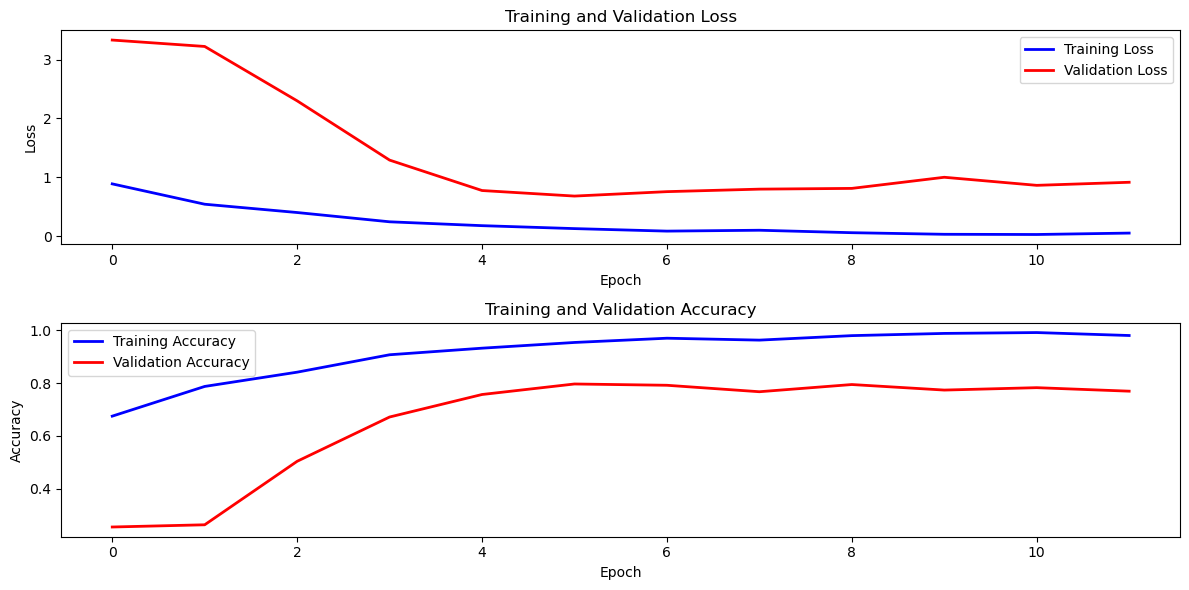

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


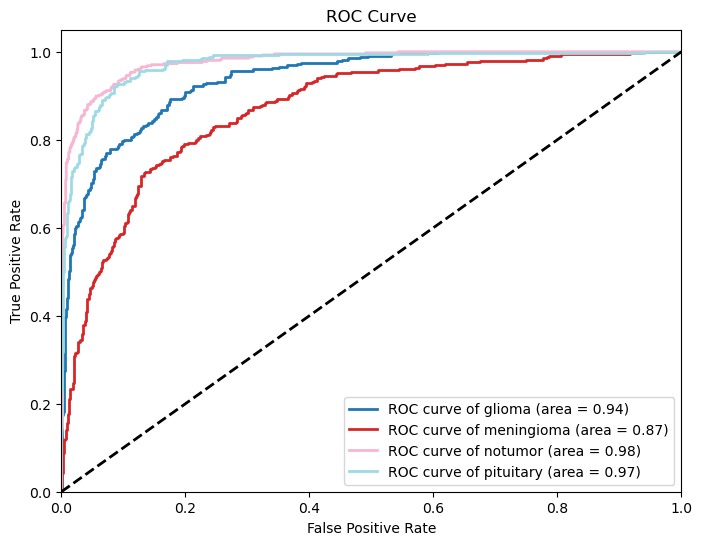

f1 score: 0.7697204555885812
Classification Report:
              precision    recall  f1-score   support

      glioma       0.72      0.78      0.75       325
  meningioma       0.62      0.66      0.64       333
     notumor       0.82      0.92      0.87       407
   pituitary       0.94      0.69      0.80       363

    accuracy                           0.77      1428
   macro avg       0.78      0.76      0.76      1428
weighted avg       0.78      0.77      0.77      1428



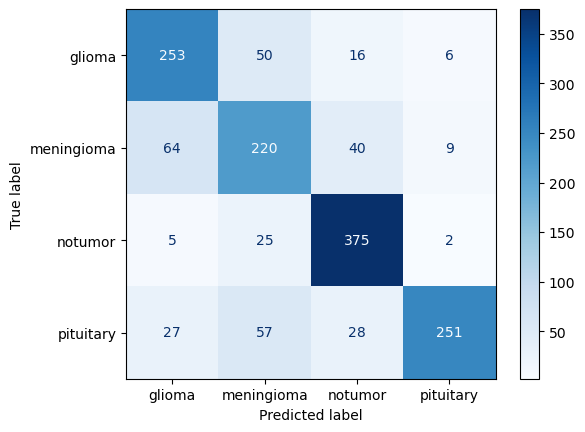

In [30]:
# plot the training curves 
plot_training_curves(history7)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.11 - increased epochs & early stopping

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=images.shape[1:], padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))  
 

    return model

# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True)

# Train the model with increased epochs and early stopping
history11 = model.fit(train_data, epochs=30,  # Increased number of epochs
                    batch_size=32,
                    validation_data=val_data,
                    callbacks=[early_stopping],  # Adding early stopping
                    verbose=1)


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_68 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 7, 7, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,366,692 (5.21 MB)

 Trainable params: 1,364,964 (5.21 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.5989 - loss: 1.1190 - val_accuracy: 0.4321 - val_loss: 2.2153
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8067 - loss: 0.5075 - val_accuracy: 0.3543 - val_loss: 2.3174
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.8626 - loss: 0.3540 - val_accuracy: 0.5175 - val_loss: 1.3498
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8990 - loss: 0.2686 - val_accuracy: 0.6765 - val_loss: 0.9864
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9340 - loss: 0.1838 - val_accuracy: 0.7129 - val_loss: 0.8922
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9266 - loss: 0.1880 - val_accuracy: 0.7556 - val_loss: 0.6946
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9720 - loss: 0.0907 - val_accuracy: 0.7423 - val_loss: 1.0660
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9817 - loss: 0.0543 - val_acc

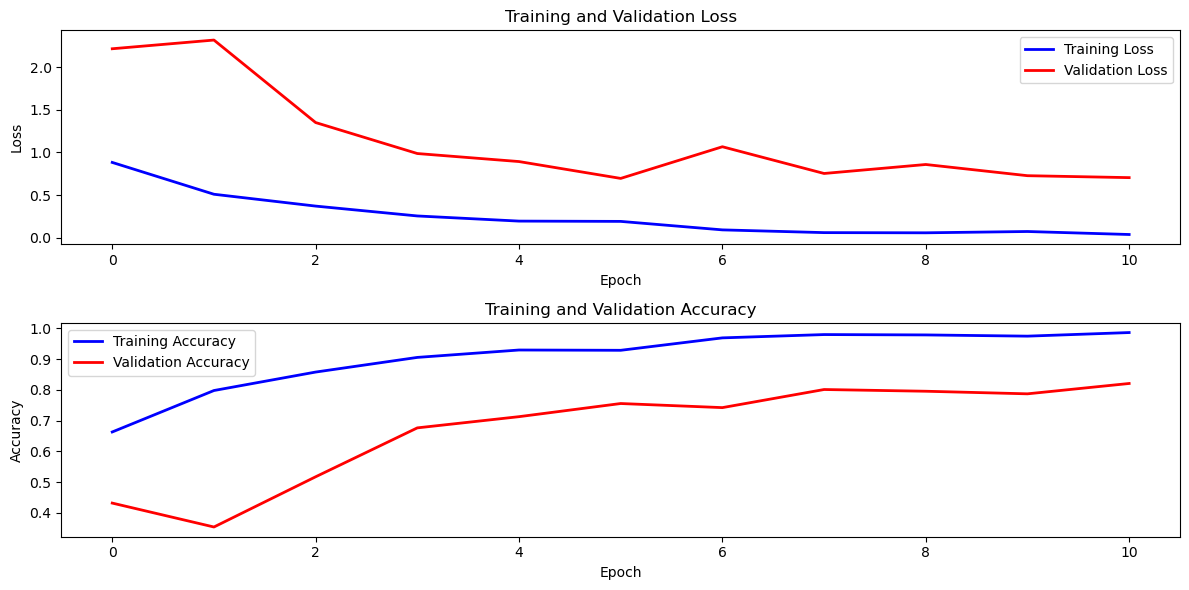

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


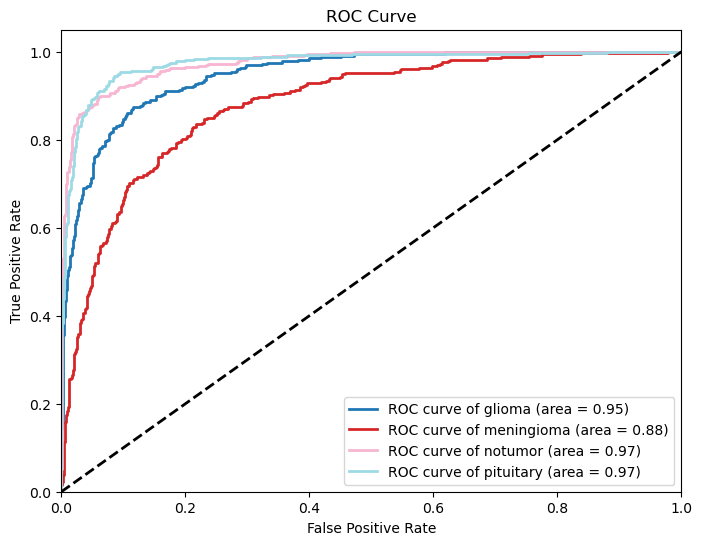

f1 score: 0.7553652737064711
Classification Report:
              precision    recall  f1-score   support

      glioma       0.80      0.73      0.76       325
  meningioma       0.60      0.73      0.66       333
     notumor       0.77      0.92      0.84       407
   pituitary       0.95      0.61      0.75       363

    accuracy                           0.76      1428
   macro avg       0.78      0.75      0.75      1428
weighted avg       0.78      0.76      0.76      1428



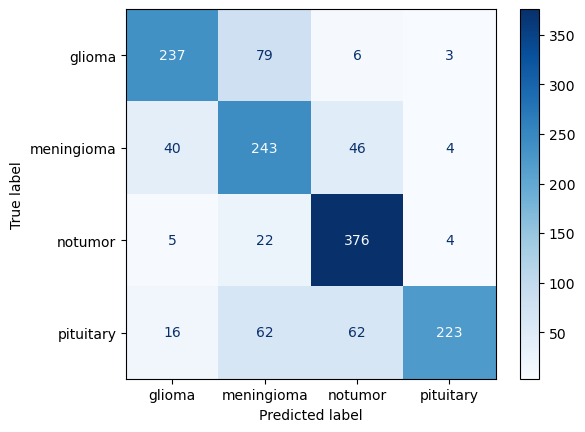

In [43]:
# plot the training curves 
plot_training_curves(history11)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.12 - increased epochs & early stopping & more dense layers

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=images.shape[1:], padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))  
 

    return model

# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               restore_best_weights=True)

# Train the model with increased epochs and early stopping
history12 = model.fit(train_data, epochs=20,  # Increased number of epochs
                    batch_size=32,
                    validation_data=val_data,
                    callbacks=[early_stopping],  # Adding early stopping
                    verbose=1)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_64 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 7, 7, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,426,740 (5.44 MB)

 Trainable params: 1,425,012 (5.44 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.5399 - loss: 1.0984 - val_accuracy: 0.2542 - val_loss: 1.8057
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.7709 - loss: 0.5807 - val_accuracy: 0.3053 - val_loss: 2.1786
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8266 - loss: 0.4365 - val_accuracy: 0.5196 - val_loss: 1.4856
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.8511 - loss: 0.3541 - val_accuracy: 0.6891 - val_loss: 0.8726
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9124 - loss: 0.2356 - val_accuracy: 0.6786 - val_loss: 1.2490
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9309 - loss: 0.1927 - val_accuracy: 0.8102 - val_loss: 0.6106
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9474 - loss: 0.1431 - val_accuracy: 0.7605 - val_loss: 0.7416
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9506 - loss: 0.1306 - val_acc

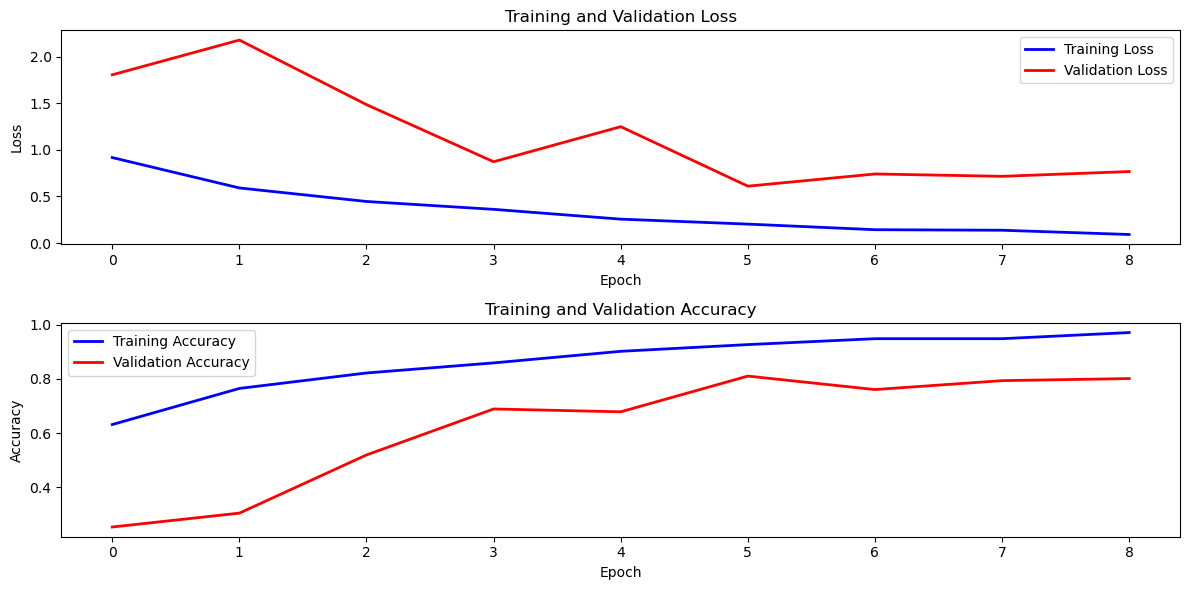

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


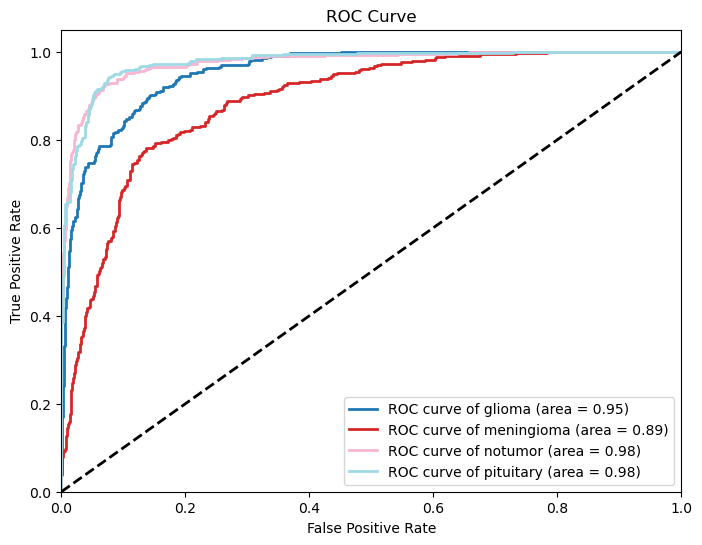

f1 score: 0.8110485250954537
Classification Report:
              precision    recall  f1-score   support

      glioma       0.82      0.77      0.79       325
  meningioma       0.66      0.71      0.69       333
     notumor       0.91      0.84      0.87       407
   pituitary       0.84      0.91      0.88       363

    accuracy                           0.81      1428
   macro avg       0.81      0.81      0.81      1428
weighted avg       0.81      0.81      0.81      1428



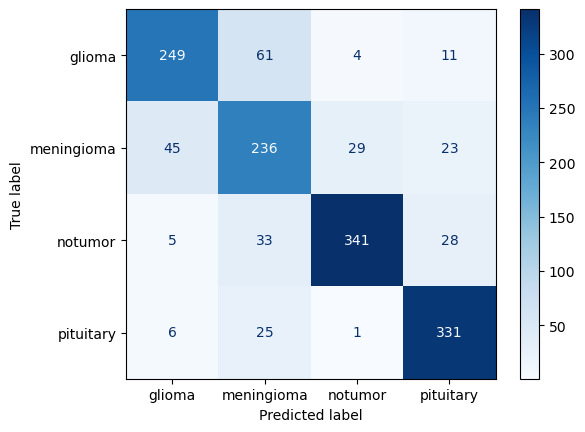

In [41]:
# plot the training curves 
plot_training_curves(history12)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.13 - increased epochs & early stopping & more dense layers & batch size 64, dropout 0.5

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=images.shape[1:], padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Adding dropout layer
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))  
 

    return model

# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               restore_best_weights=True)

# Train the model with increased epochs and early stopping
history13 = model.fit(train_data, epochs=30,  # Increased number of epochs
                    batch_size=64,
                    validation_data=val_data,
                    callbacks=[early_stopping],  # Adding early stopping
                    verbose=1)


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 7, 7, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,426,740 (5.44 MB)

 Trainable params: 1,425,012 (5.44 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.4938 - loss: 1.1991 - val_accuracy: 0.4328 - val_loss: 1.6927
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.6966 - loss: 0.7809 - val_accuracy: 0.2710 - val_loss: 1.5036
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.7580 - loss: 0.6273 - val_accuracy: 0.5063 - val_loss: 1.5147
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.7960 - loss: 0.5063 - val_accuracy: 0.6169 - val_loss: 1.0053
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8416 - loss: 0.4331 - val_accuracy: 0.7850 - val_loss: 0.6689
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.8577 - loss: 0.3745 - val_accuracy: 0.7430 - val_loss: 0.7707
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.8890 - loss: 0.2838 - val_accuracy: 0.7682 - val_loss: 0.6688
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9059 - loss: 0.2623 - val_acc

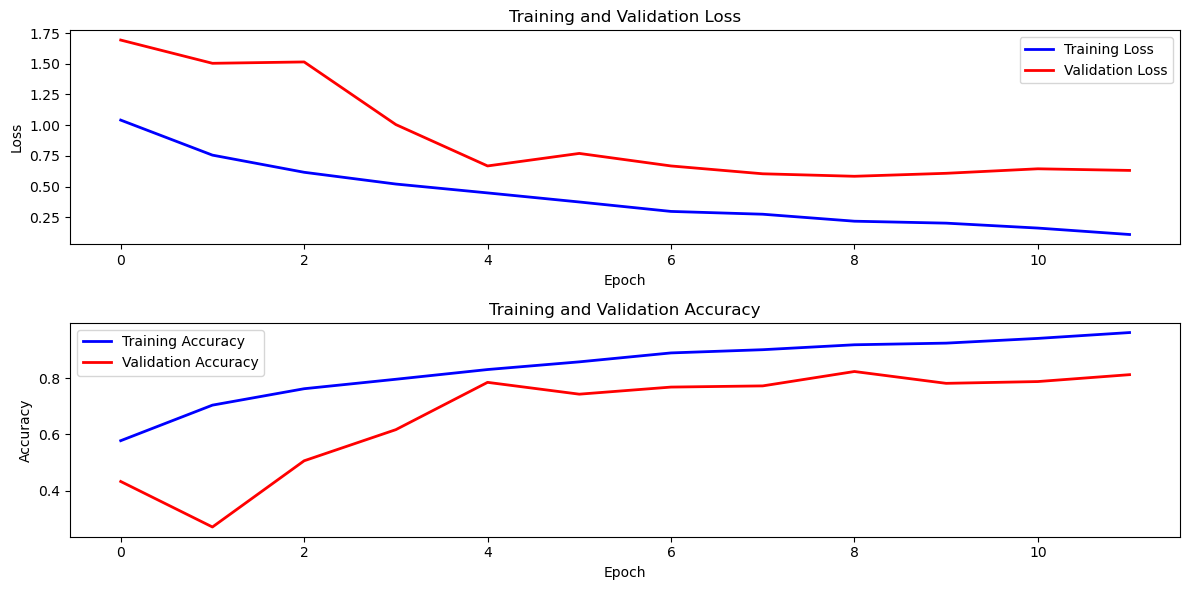

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


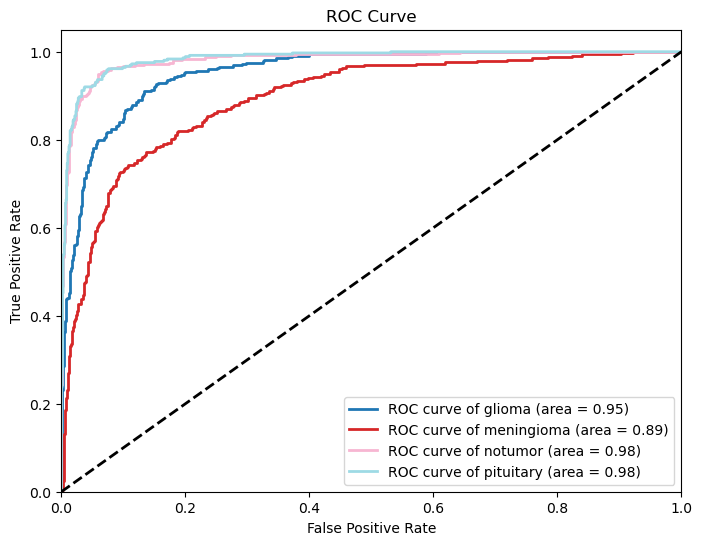

f1 score: 0.8194657224077879
Classification Report:
              precision    recall  f1-score   support

      glioma       0.79      0.80      0.79       325
  meningioma       0.75      0.62      0.68       333
     notumor       0.91      0.89      0.90       407
   pituitary       0.81      0.96      0.88       363

    accuracy                           0.82      1428
   macro avg       0.82      0.82      0.81      1428
weighted avg       0.82      0.82      0.82      1428



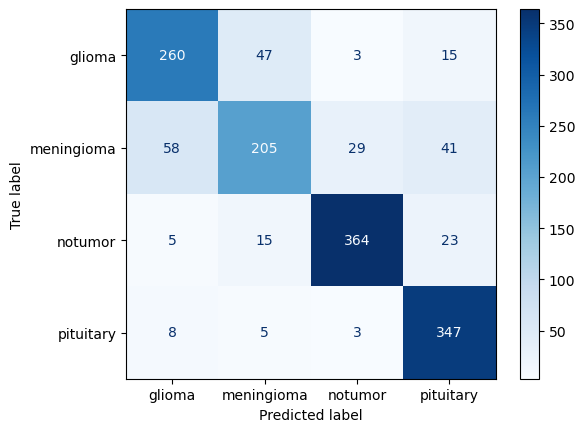

In [45]:
# plot the training curves 
plot_training_curves(history13)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.14 - dropout 0.25 & more training epochs & higher batch size 128

In [49]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= images.shape[1:], padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu',padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(Dropout(0.25))  # Adding dropout layer
    model.add(layers.Dense(4, activation='softmax'))  

    return model


# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               restore_best_weights=True)

# Train the model with increased epochs and early stopping
history13 = model.fit(train_data, epochs=30,  # Increased number of epochs
                    batch_size=128,
                    validation_data=val_data,
                    callbacks=[early_stopping],  # Adding early stopping
                    verbose=1)






c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_84 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 7, 7, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,366,820 (5.21 MB)

 Trainable params: 1,365,028 (5.21 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.5977 - loss: 1.0673 - val_accuracy: 0.2542 - val_loss: 3.0798
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.7734 - loss: 0.5844 - val_accuracy: 0.4426 - val_loss: 2.6777
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8468 - loss: 0.4124 - val_accuracy: 0.4741 - val_loss: 2.1529
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.8984 - loss: 0.2977 - val_accuracy: 0.5959 - val_loss: 1.1854
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9362 - loss: 0.2009 - val_accuracy: 0.7066 - val_loss: 0.9244
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9407 - loss: 0.1558 - val_accuracy: 0.7948 - val_loss: 0.6368
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9641 - loss: 0.1261 - val_accuracy: 0.7500 - val_loss: 0.8155
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9665 - loss: 0.1078 - val_acc

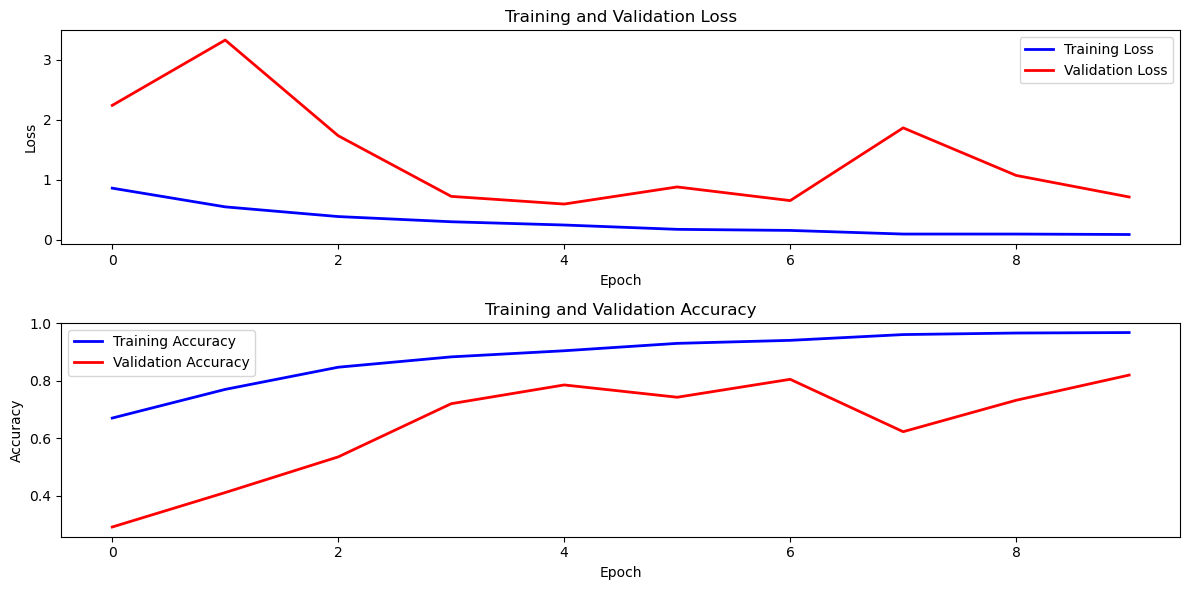

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


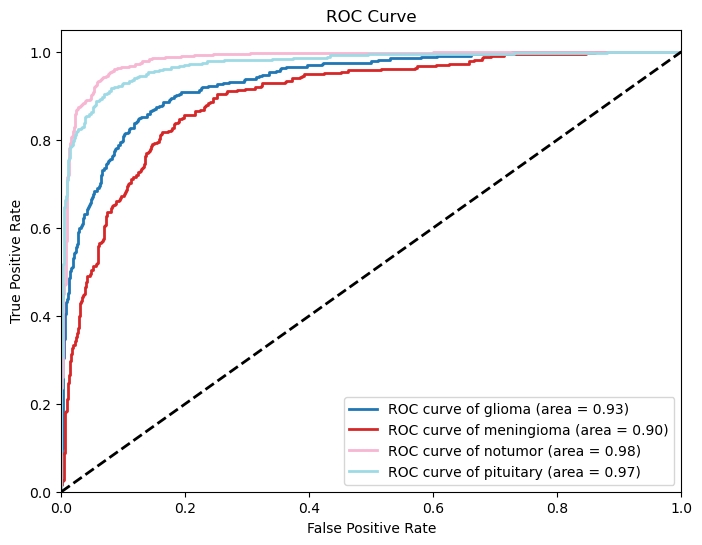

f1 score: 0.7984348700620487
Classification Report:
              precision    recall  f1-score   support

      glioma       0.77      0.69      0.73       325
  meningioma       0.62      0.78      0.69       333
     notumor       0.89      0.89      0.89       407
   pituitary       0.93      0.80      0.86       363

    accuracy                           0.79      1428
   macro avg       0.80      0.79      0.79      1428
weighted avg       0.81      0.79      0.80      1428



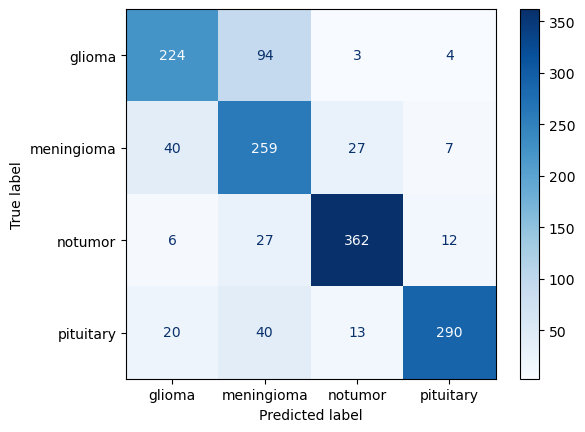

In [50]:
# plot the training curves 
plot_training_curves(history6)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.15 - SIMPLIFY MODEL: one less conv layer, only one extra dense layer & extra epochs + early stopping

In [58]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= images.shape[1:], padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu',padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))   

    return model


# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               restore_best_weights=True)

# Train the model with increased epochs and early stopping
history15 = model.fit(train_data, epochs=30,  # Increased number of epochs
                    batch_size=32,
                    validation_data=val_data,
                    callbacks=[early_stopping],  # Adding early stopping
                    verbose=1)






c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_103 (Conv2D)             │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_103               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_104               │ (None, 7, 7, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_105               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,668 (975.27 KB)

 Trainable params: 249,220 (973.52 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5833 - loss: 1.0275 - val_accuracy: 0.2290 - val_loss: 2.0451
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7909 - loss: 0.5560 - val_accuracy: 0.2990 - val_loss: 2.4217
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8377 - loss: 0.4118 - val_accuracy: 0.4209 - val_loss: 1.3427
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8813 - loss: 0.3040 - val_accuracy: 0.6499 - val_loss: 1.0584
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9218 - loss: 0.2139 - val_accuracy: 0.7570 - val_loss: 0.6263
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9504 - loss: 0.1537 - val_accuracy: 0.7633 - val_loss: 0.8036
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9668 - loss: 0.0962 - val_accuracy: 0.8242 - val_loss: 0.7514
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9807 - loss: 0.0637 - val_accu

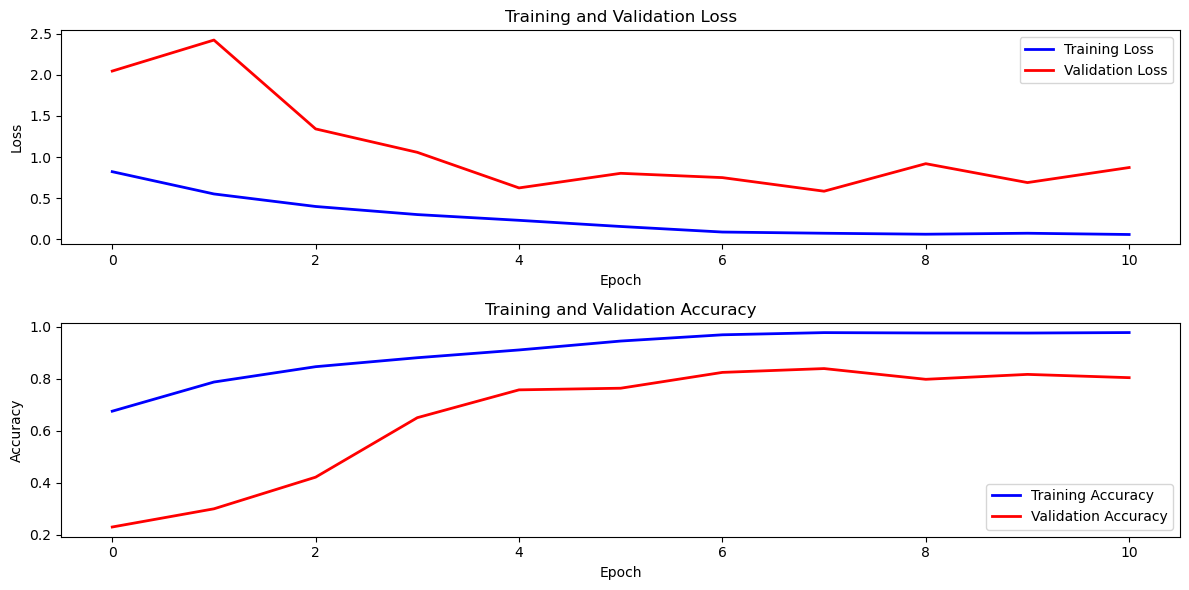

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


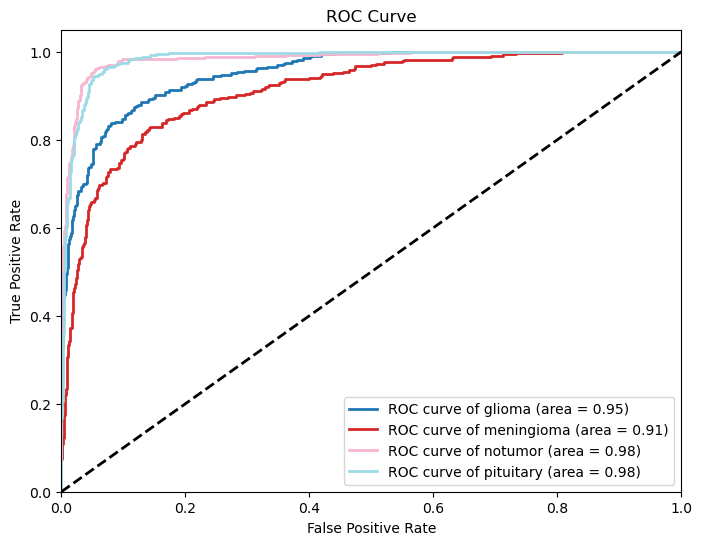

f1 score: 0.8371495475790407
Classification Report:
              precision    recall  f1-score   support

      glioma       0.82      0.74      0.78       325
  meningioma       0.74      0.73      0.73       333
     notumor       0.89      0.95      0.92       407
   pituitary       0.88      0.91      0.90       363

    accuracy                           0.84      1428
   macro avg       0.83      0.83      0.83      1428
weighted avg       0.84      0.84      0.84      1428



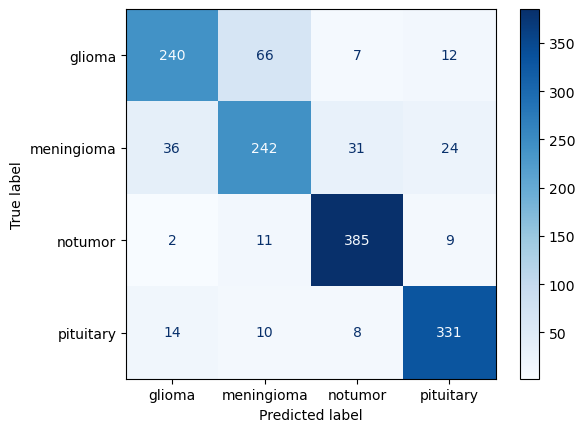

In [59]:
# plot the training curves 
plot_training_curves(history15)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.15.1 - batch size 64

In [60]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= images.shape[1:], padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu',padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))   

    return model


# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               restore_best_weights=True)

# Train the model with increased epochs and early stopping
history15 = model.fit(train_data, epochs=30,  # Increased number of epochs
                    batch_size=64,
                    validation_data=val_data,
                    callbacks=[early_stopping],  # Adding early stopping
                    verbose=1)






c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_106 (Conv2D)             │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_106               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_107               │ (None, 7, 7, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_118         │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_108               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,668 (975.27 KB)

 Trainable params: 249,220 (973.52 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.5520 - loss: 1.1448 - val_accuracy: 0.2850 - val_loss: 2.3449
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7738 - loss: 0.5566 - val_accuracy: 0.4370 - val_loss: 1.7815
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8543 - loss: 0.3739 - val_accuracy: 0.5497 - val_loss: 1.7099
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9007 - loss: 0.2555 - val_accuracy: 0.7087 - val_loss: 0.8677
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9408 - loss: 0.1713 - val_accuracy: 0.7878 - val_loss: 0.7009
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9458 - loss: 0.1451 - val_accuracy: 0.8074 - val_loss: 0.5776
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9718 - loss: 0.0845 - val_accuracy: 0.7801 - val_loss: 0.8248
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9743 - loss: 0.0693 - val_accu

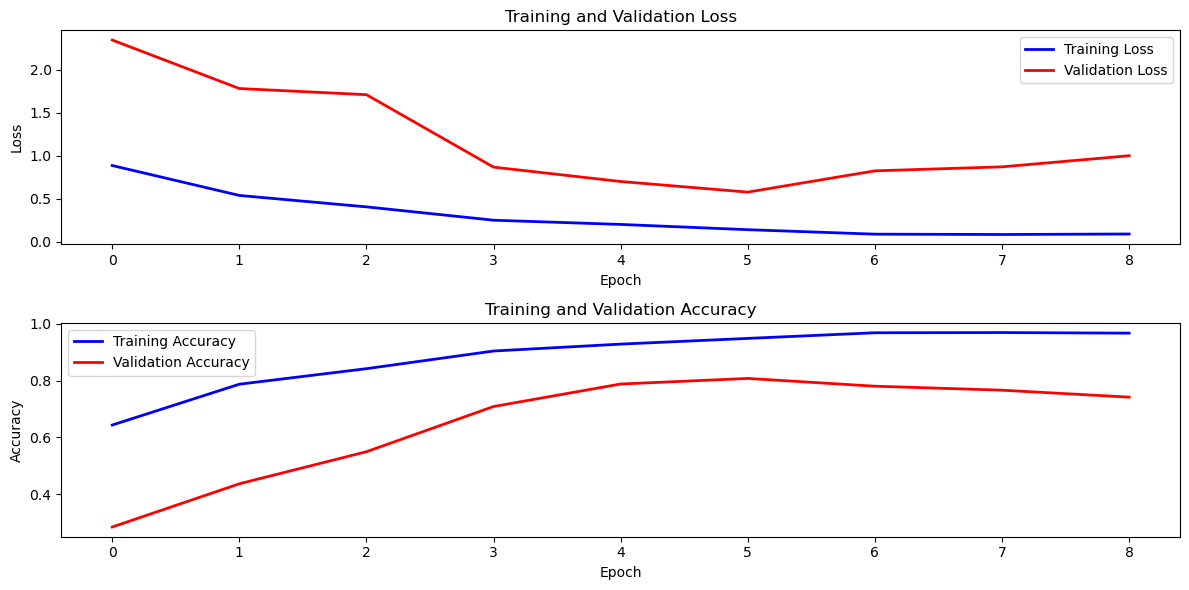

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


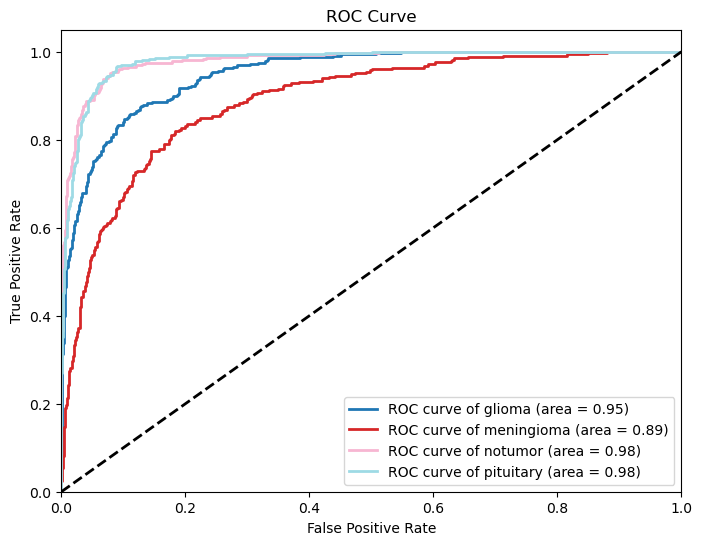

f1 score: 0.8076621582650172
Classification Report:
              precision    recall  f1-score   support

      glioma       0.75      0.78      0.77       325
  meningioma       0.67      0.66      0.67       333
     notumor       0.92      0.86      0.89       407
   pituitary       0.86      0.91      0.88       363

    accuracy                           0.81      1428
   macro avg       0.80      0.80      0.80      1428
weighted avg       0.81      0.81      0.81      1428



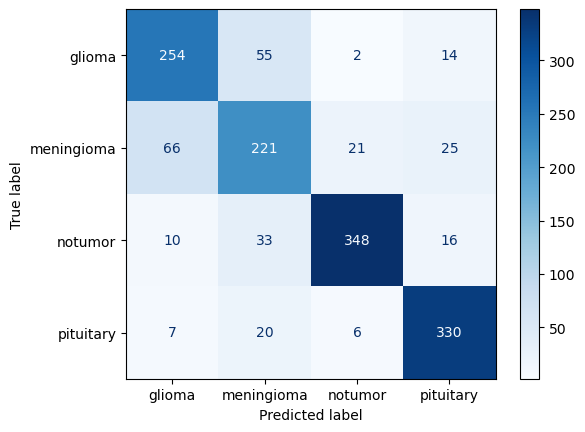

In [61]:
# plot the training curves 
plot_training_curves(history15)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.15.2 - dropout 0.5

In [64]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= images.shape[1:], padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu',padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Adding dropout layer
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))   

    return model


# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True)

# Train the model with increased epochs and early stopping
history15 = model.fit(train_data, epochs=30,  # Increased number of epochs
                    batch_size=32,
                    validation_data=val_data,
                    callbacks=[early_stopping],  # Adding early stopping
                    verbose=1)






c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_112 (Conv2D)             │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_122         │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_112               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_123         │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_113               │ (None, 7, 7, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_124         │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_114               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,668 (975.27 KB)

 Trainable params: 249,220 (973.52 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.4805 - loss: 1.3388 - val_accuracy: 0.2283 - val_loss: 1.8214
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6710 - loss: 0.8061 - val_accuracy: 0.4804 - val_loss: 1.3357
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7417 - loss: 0.6456 - val_accuracy: 0.5798 - val_loss: 1.3643
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7557 - loss: 0.6008 - val_accuracy: 0.6954 - val_loss: 0.7842
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7905 - loss: 0.5152 - val_accuracy: 0.7654 - val_loss: 0.5821
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8169 - loss: 0.4596 - val_accuracy: 0.7787 - val_loss: 0.5528
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8457 - loss: 0.3784 - val_accuracy: 0.8256 - val_loss: 0.4720
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8798 - loss: 0.3074 - val_accu

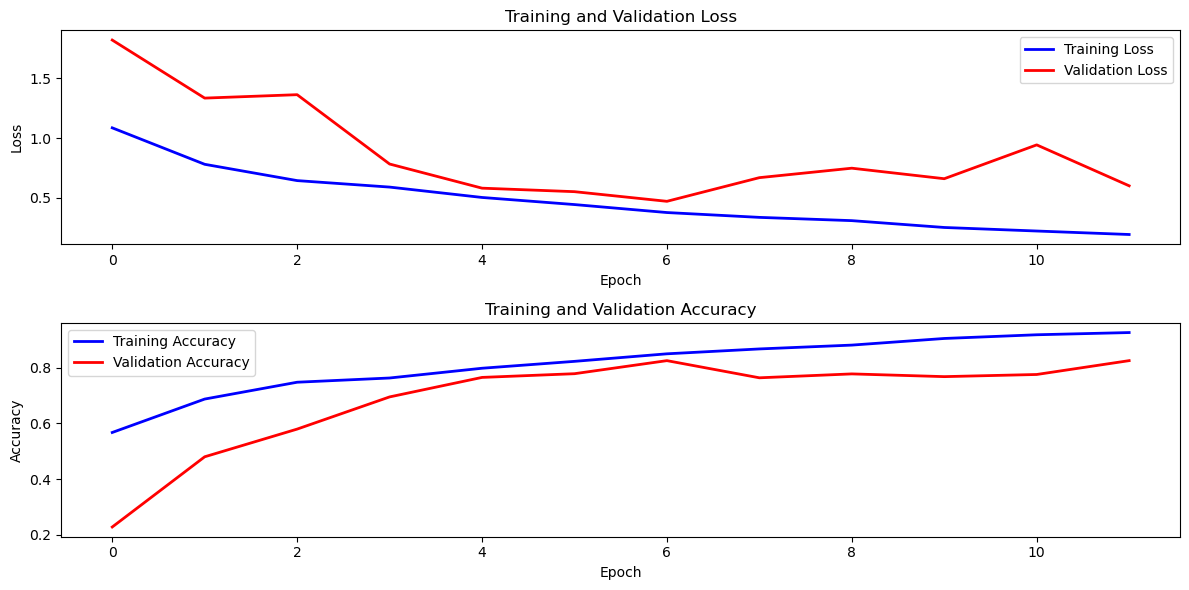

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


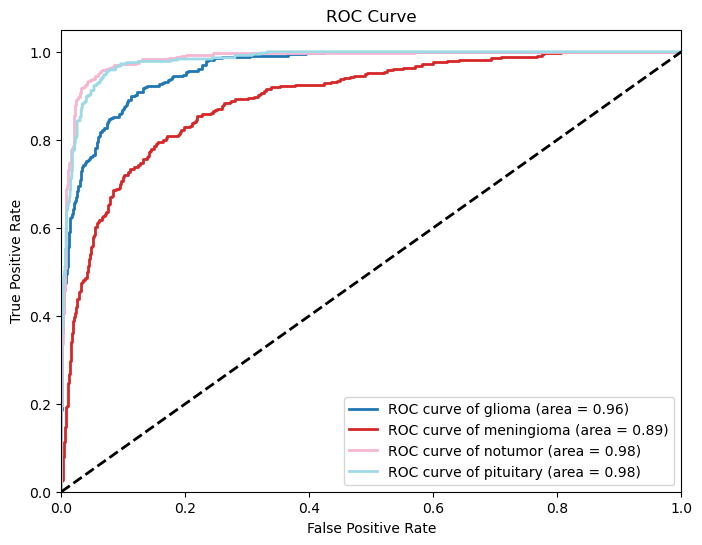

f1 score: 0.8258587342141358
Classification Report:
              precision    recall  f1-score   support

      glioma       0.84      0.75      0.79       325
  meningioma       0.67      0.71      0.69       333
     notumor       0.93      0.90      0.92       407
   pituitary       0.85      0.92      0.88       363

    accuracy                           0.83      1428
   macro avg       0.82      0.82      0.82      1428
weighted avg       0.83      0.83      0.83      1428



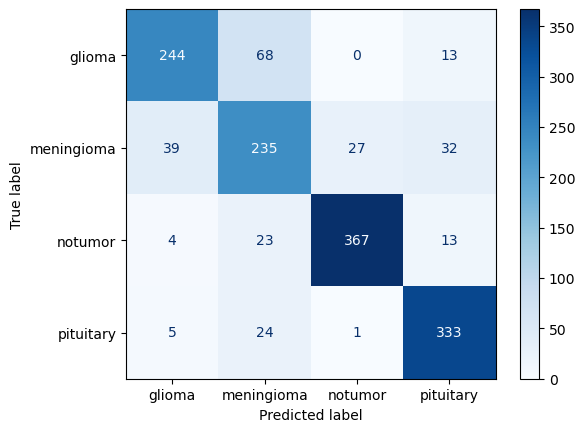

In [65]:
# plot the training curves 
plot_training_curves(history15)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.15.3 - dropout 0.25

In [66]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= images.shape[1:], padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu',padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(Dropout(0.25))  # Adding dropout layer
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))   

    return model


# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True)

# Train the model with increased epochs and early stopping
history15 = model.fit(train_data, epochs=30,  # Increased number of epochs
                    batch_size=32,
                    validation_data=val_data,
                    callbacks=[early_stopping],  # Adding early stopping
                    verbose=1)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_115 (Conv2D)             │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_125         │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_115               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_126         │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_116               │ (None, 7, 7, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_127         │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_117               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,668 (975.27 KB)

 Trainable params: 249,220 (973.52 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.5199 - loss: 1.2633 - val_accuracy: 0.4181 - val_loss: 2.1068
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7196 - loss: 0.7242 - val_accuracy: 0.3333 - val_loss: 2.2518
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8056 - loss: 0.5137 - val_accuracy: 0.5889 - val_loss: 1.7576
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8138 - loss: 0.4600 - val_accuracy: 0.6765 - val_loss: 0.9995
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8549 - loss: 0.3694 - val_accuracy: 0.7619 - val_loss: 0.6670
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8887 - loss: 0.2905 - val_accuracy: 0.8060 - val_loss: 0.5434
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9029 - loss: 0.2564 - val_accuracy: 0.7815 - val_loss: 0.7099
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9153 - loss: 0.2187 - val_accu

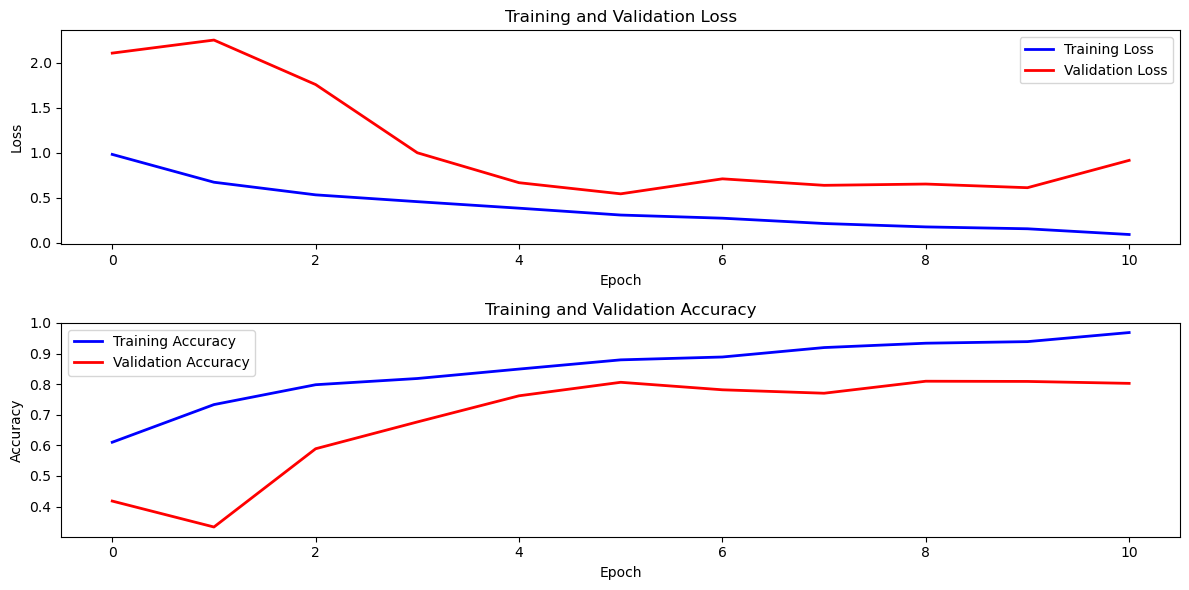

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


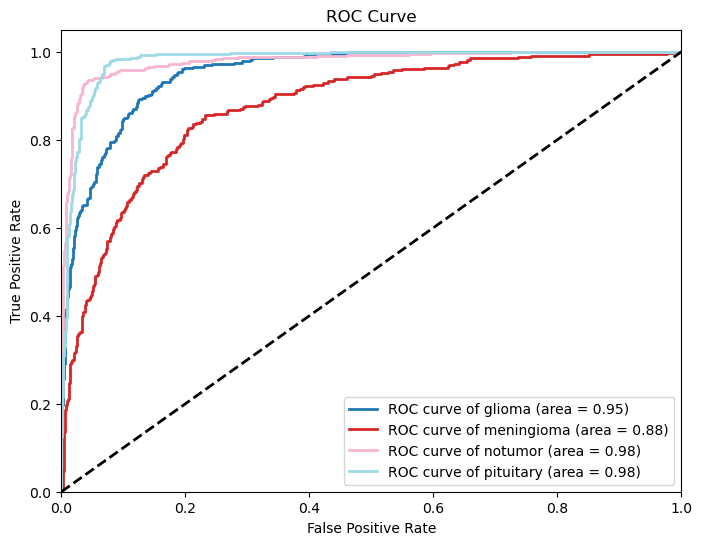

f1 score: 0.8040089846580294
Classification Report:
              precision    recall  f1-score   support

      glioma       0.74      0.79      0.77       325
  meningioma       0.66      0.60      0.63       333
     notumor       0.90      0.94      0.92       407
   pituitary       0.88      0.86      0.87       363

    accuracy                           0.81      1428
   macro avg       0.80      0.80      0.80      1428
weighted avg       0.80      0.81      0.80      1428



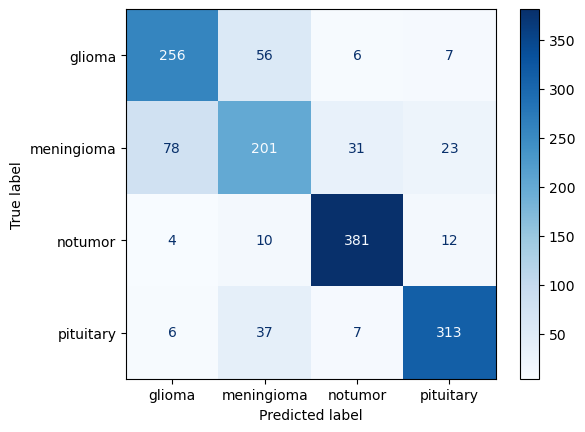

In [67]:
# plot the training curves 
plot_training_curves(history15)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.15.4 - Nadam optimizer

In [102]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= images.shape[1:], padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu',padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))   

    return model


# Instantiate the model
model = enhanced()

model.compile(optimizer=Nadam(),
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               restore_best_weights=True)

# Train the model with increased epochs and early stopping
history15 = model.fit(train_data, epochs=30,  # Increased number of epochs
                    batch_size=32,
                    validation_data=val_data,
                    callbacks=[early_stopping],  # Adding early stopping
                    verbose=1)






c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_163 (Conv2D)             │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_175         │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_163               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_164 (Conv2D)             │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_176         │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_164               │ (None, 7, 7, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_165 (Conv2D)             │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_177         │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_165               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_46 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,668 (975.27 KB)

 Trainable params: 249,220 (973.52 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5906 - loss: 1.0154 - val_accuracy: 0.2850 - val_loss: 2.2694
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8027 - loss: 0.5036 - val_accuracy: 0.2850 - val_loss: 3.7970
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8726 - loss: 0.3474 - val_accuracy: 0.4748 - val_loss: 3.5203
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9038 - loss: 0.2368 - val_accuracy: 0.6534 - val_loss: 1.3409
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9386 - loss: 0.1662 - val_accuracy: 0.7822 - val_loss: 0.6802
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9599 - loss: 0.1075 - val_accuracy: 0.7682 - val_loss: 0.7650
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9787 - loss: 0.0655 - val_accuracy: 0.7535 - val_loss: 0.9362
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9832 - loss: 0.0436 - val_acc

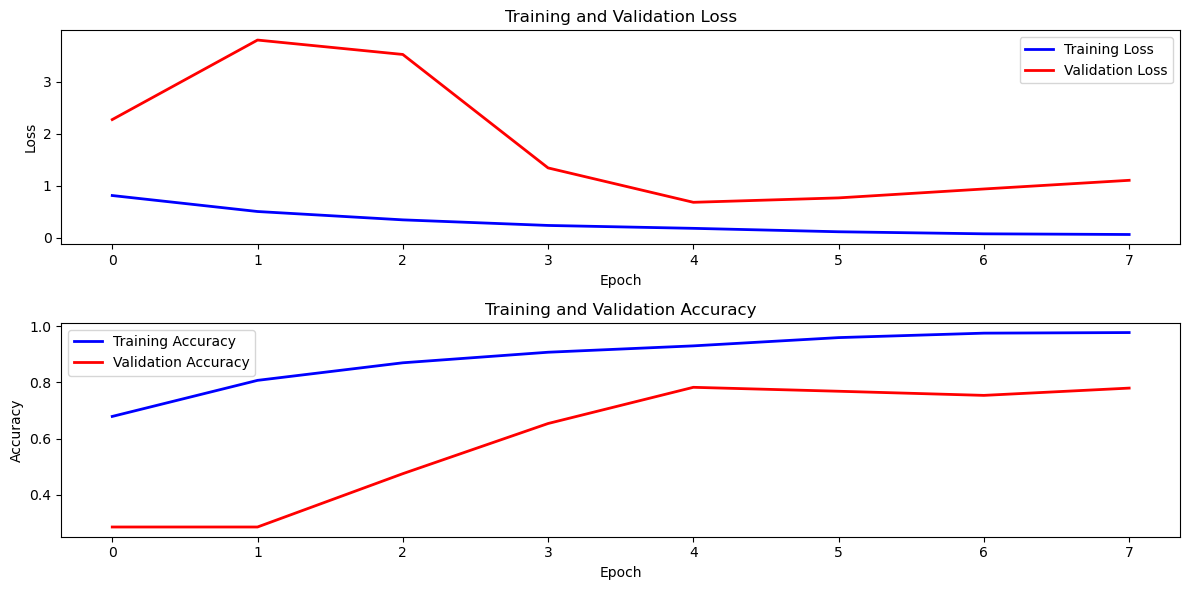

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


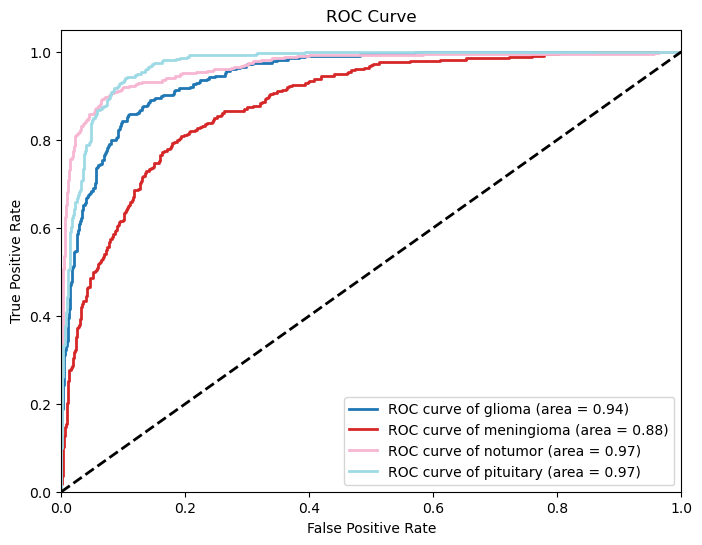

f1 score: 0.7769588112189592
Classification Report:
              precision    recall  f1-score   support

      glioma       0.77      0.75      0.76       325
  meningioma       0.69      0.56      0.62       333
     notumor       0.86      0.86      0.86       407
   pituitary       0.78      0.93      0.84       363

    accuracy                           0.78      1428
   macro avg       0.77      0.77      0.77      1428
weighted avg       0.78      0.78      0.78      1428



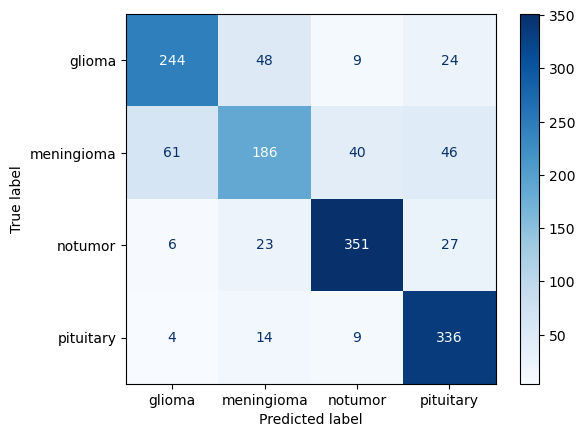

In [103]:
# plot the training curves 
plot_training_curves(history15)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.15.5 - no batch norm

In [112]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= images.shape[1:], padding = "same" ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = "same" ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu',padding = "same" ))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))   

    return model


# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               restore_best_weights=True)

# Train the model with increased epochs and early stopping
history15 = model.fit(train_data, epochs=30,  # Increased number of epochs
                    batch_size=32,
                    validation_data=val_data,
                    callbacks=[early_stopping],  # Adding early stopping
                    verbose=1)






c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_177 (Conv2D)             │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_177               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_178 (Conv2D)             │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_178               │ (None, 7, 7, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_179 (Conv2D)             │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_179               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_51 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,772 (971.77 KB)

 Trainable params: 248,772 (971.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.4231 - loss: 1.1973 - val_accuracy: 0.6919 - val_loss: 0.8182
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7061 - loss: 0.7662 - val_accuracy: 0.7045 - val_loss: 0.7350
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7760 - loss: 0.5919 - val_accuracy: 0.7360 - val_loss: 0.7147
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7874 - loss: 0.5411 - val_accuracy: 0.7724 - val_loss: 0.5582
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8256 - loss: 0.4449 - val_accuracy: 0.8151 - val_loss: 0.4988
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8587 - loss: 0.3750 - val_accuracy: 0.8277 - val_loss: 0.4716
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8777 - loss: 0.3110 - val_accuracy: 0.8312 - val_loss: 0.4763
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9102 - loss: 0.2620 - val_accu

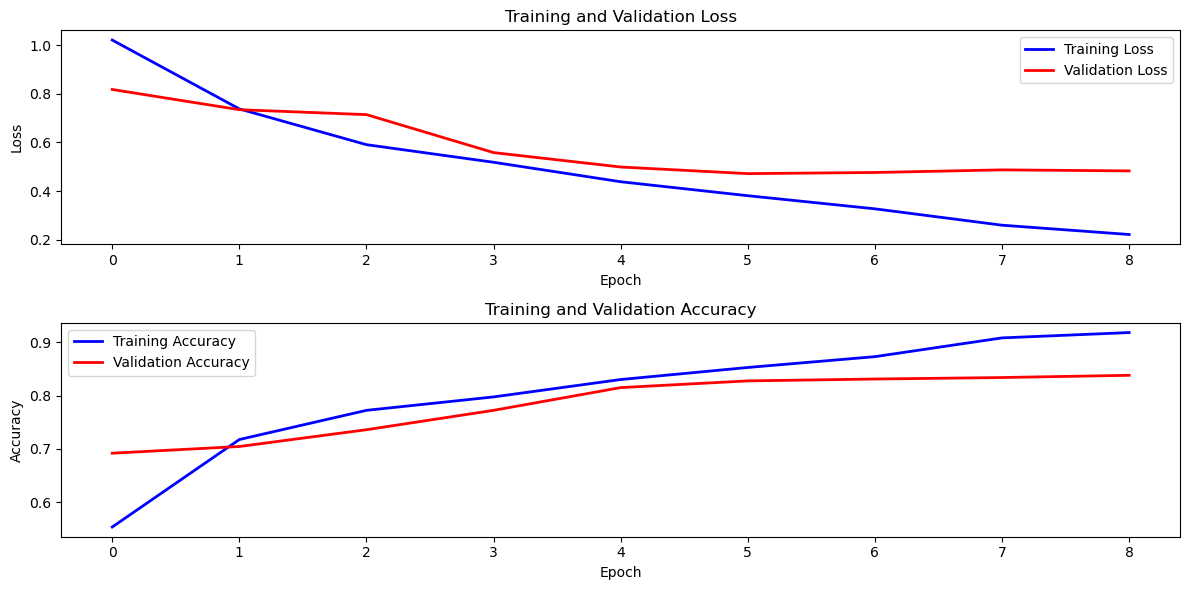

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


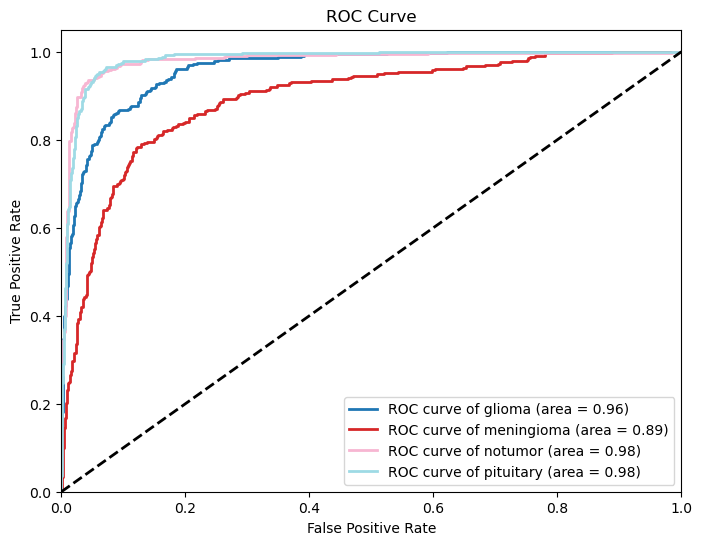

f1 score: 0.8276031131186601
Classification Report:
              precision    recall  f1-score   support

      glioma       0.87      0.71      0.78       325
  meningioma       0.67      0.74      0.70       333
     notumor       0.88      0.94      0.91       407
   pituitary       0.90      0.89      0.89       363

    accuracy                           0.83      1428
   macro avg       0.83      0.82      0.82      1428
weighted avg       0.83      0.83      0.83      1428



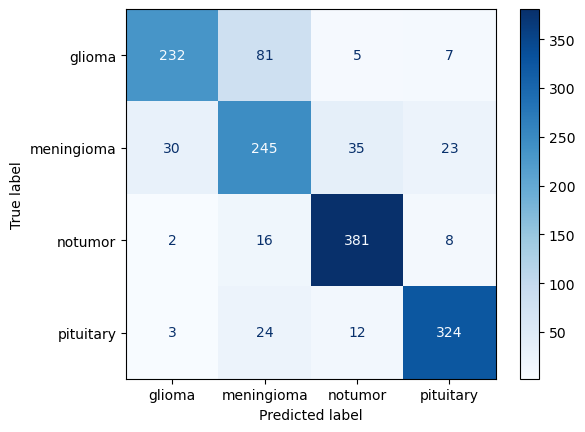

In [113]:
# plot the training curves 
plot_training_curves(history15)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

##  4.15.6 - no increased number of filters

In [106]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= images.shape[1:], padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu',padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))   

    return model


# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               restore_best_weights=True)

# Train the model with increased epochs and early stopping
history15 = model.fit(train_data, epochs=30,  # Increased number of epochs
                    batch_size=32,
                    validation_data=val_data,
                    callbacks=[early_stopping],  # Adding early stopping
                    verbose=1)






c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_169 (Conv2D)             │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_178         │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_169               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_170 (Conv2D)             │ (None, 15, 15, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_179         │ (None, 15, 15, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_170               │ (None, 7, 7, 32)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_171 (Conv2D)             │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_180         │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_171               │ (None, 3, 3, 32)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_48 (Flatten)            │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 128)            │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,708 (252.77 KB)

 Trainable params: 64,516 (252.02 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5570 - loss: 1.0446 - val_accuracy: 0.4272 - val_loss: 1.5848
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7762 - loss: 0.5642 - val_accuracy: 0.3803 - val_loss: 1.9838
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8332 - loss: 0.4286 - val_accuracy: 0.6282 - val_loss: 1.1462
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8633 - loss: 0.3479 - val_accuracy: 0.7297 - val_loss: 0.7132
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8973 - loss: 0.2549 - val_accuracy: 0.7766 - val_loss: 0.6150
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9090 - loss: 0.2349 - val_accuracy: 0.7689 - val_loss: 0.6554
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9457 - loss: 0.1418 - val_accuracy: 0.7773 - val_loss: 0.7907
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9630 - loss: 0.1063 - val_accu

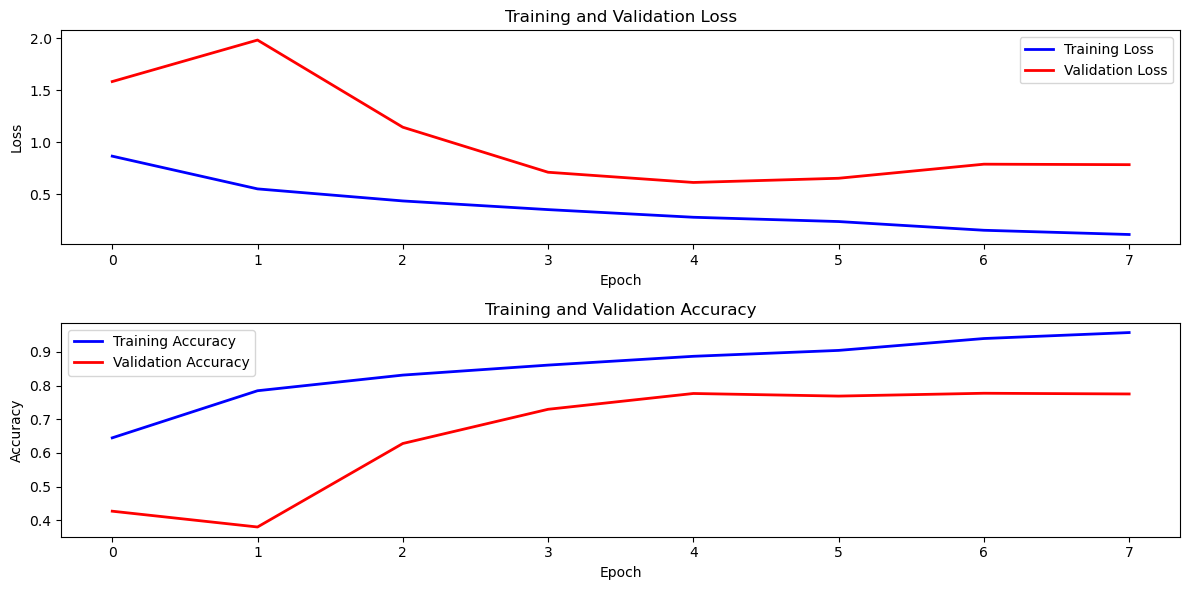

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


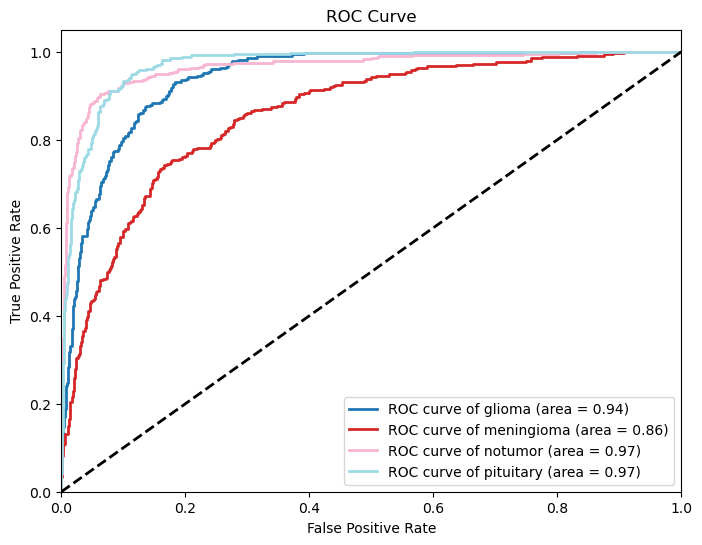

f1 score: 0.771782437785569
Classification Report:
              precision    recall  f1-score   support

      glioma       0.76      0.69      0.72       325
  meningioma       0.66      0.57      0.61       333
     notumor       0.87      0.89      0.88       407
   pituitary       0.78      0.92      0.84       363

    accuracy                           0.78      1428
   macro avg       0.77      0.77      0.76      1428
weighted avg       0.77      0.78      0.77      1428



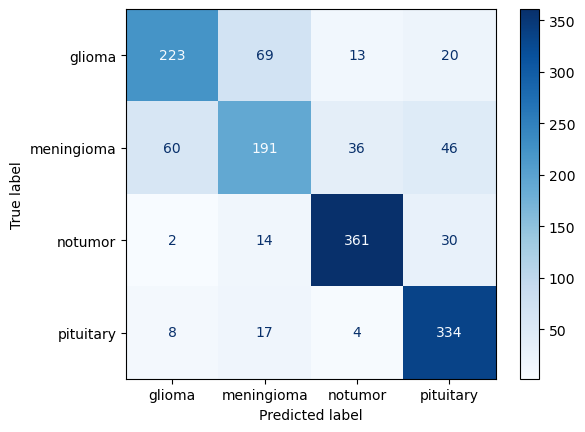

In [107]:
# plot the training curves 
plot_training_curves(history15)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.15.7 - no extra conv layer

In [108]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= images.shape[1:], padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = "same" ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))   

    return model


# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               restore_best_weights=True)

# Train the model with increased epochs and early stopping
history15 = model.fit(train_data, epochs=30,  # Increased number of epochs
                    batch_size=32,
                    validation_data=val_data,
                    callbacks=[early_stopping],  # Adding early stopping
                    verbose=1)






c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_172 (Conv2D)             │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_181         │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_172               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_173 (Conv2D)             │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_182         │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_173               │ (None, 7, 7, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_49 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,252 (1.64 MB)

 Trainable params: 429,060 (1.64 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5830 - loss: 1.1574 - val_accuracy: 0.2843 - val_loss: 1.8132
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8057 - loss: 0.5195 - val_accuracy: 0.4853 - val_loss: 1.1683
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8619 - loss: 0.3635 - val_accuracy: 0.5987 - val_loss: 0.9712
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9132 - loss: 0.2368 - val_accuracy: 0.6884 - val_loss: 0.7934
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9536 - loss: 0.1289 - val_accuracy: 0.7990 - val_loss: 0.5779
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9695 - loss: 0.0843 - val_accuracy: 0.7773 - val_loss: 0.6893
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9828 - loss: 0.0583 - val_accuracy: 0.7920 - val_loss: 0.7617
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9852 - loss: 0.0418 - val_accu

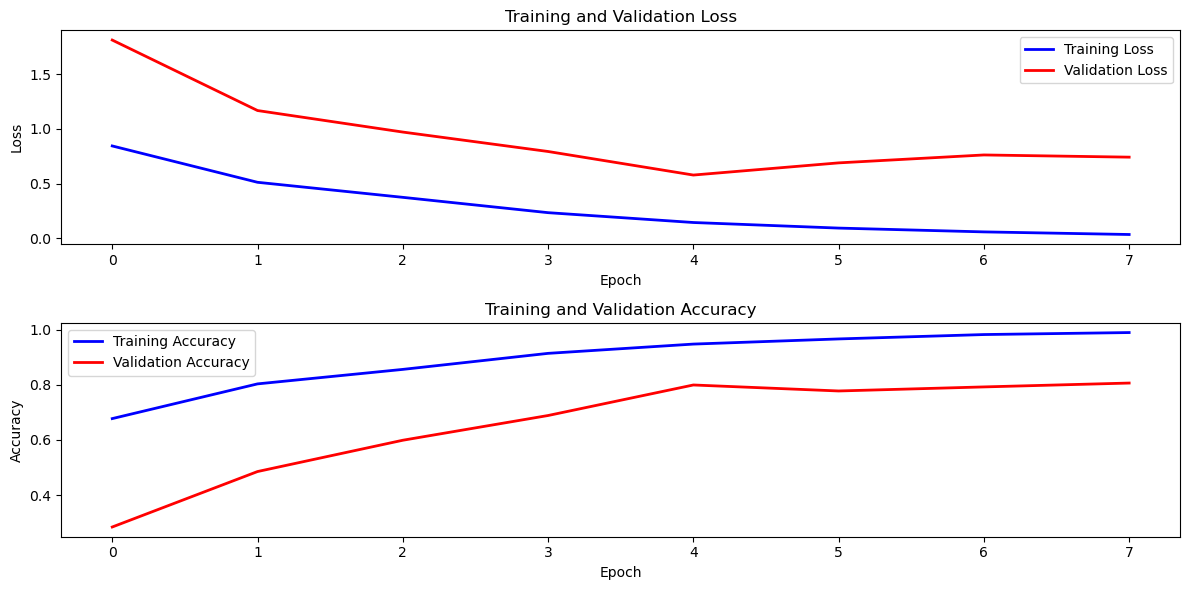

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


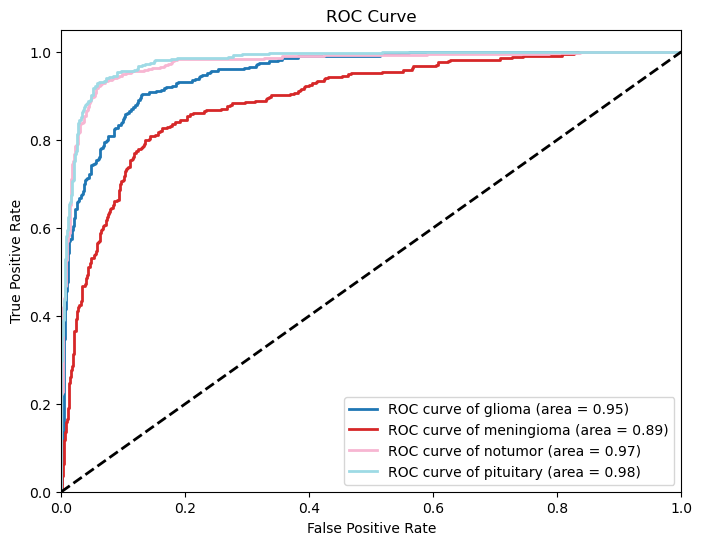

f1 score: 0.7879502065862175
Classification Report:
              precision    recall  f1-score   support

      glioma       0.68      0.88      0.77       325
  meningioma       0.79      0.46      0.58       333
     notumor       0.86      0.91      0.88       407
   pituitary       0.86      0.92      0.89       363

    accuracy                           0.80      1428
   macro avg       0.80      0.79      0.78      1428
weighted avg       0.80      0.80      0.79      1428



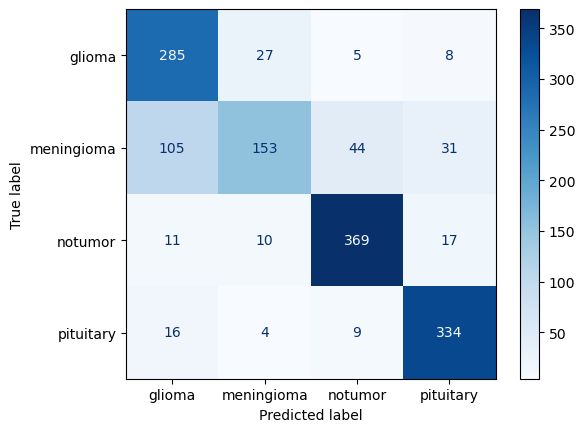

In [109]:
# plot the training curves 
plot_training_curves(history15)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)

## 4.15.8 - no zero-padding

In [110]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization

def enhanced():   
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= images.shape[1:]))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))   

    return model


# Instantiate the model
model = enhanced()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               restore_best_weights=True)

# Train the model with increased epochs and early stopping
history15 = model.fit(train_data, epochs=30,  # Increased number of epochs
                    batch_size=32,
                    validation_data=val_data,
                    callbacks=[early_stopping],  # Adding early stopping
                    verbose=1)






c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_174 (Conv2D)             │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_183         │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_174               │ (None, 14, 14, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_175 (Conv2D)             │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_184         │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_175               │ (None, 6, 6, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_176 (Conv2D)             │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_185         │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_176               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_50 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,748 (655.27 KB)

 Trainable params: 167,300 (653.52 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5828 - loss: 1.0168 - val_accuracy: 0.2549 - val_loss: 1.7568
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8154 - loss: 0.4971 - val_accuracy: 0.3137 - val_loss: 2.1433
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8572 - loss: 0.3661 - val_accuracy: 0.5553 - val_loss: 1.3222
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9105 - loss: 0.2301 - val_accuracy: 0.7612 - val_loss: 0.6159
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9492 - loss: 0.1425 - val_accuracy: 0.7801 - val_loss: 0.7144
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9488 - loss: 0.1437 - val_accuracy: 0.7843 - val_loss: 0.6986
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9661 - loss: 0.1063 - val_accuracy: 0.7626 - val_loss: 0.7361


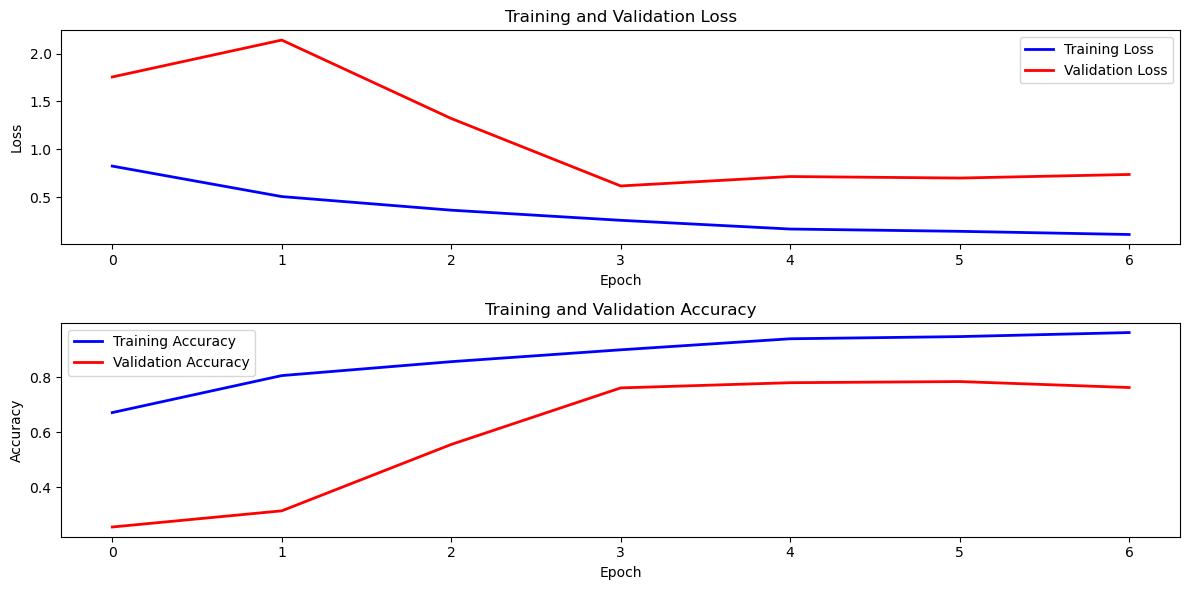

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_20228\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


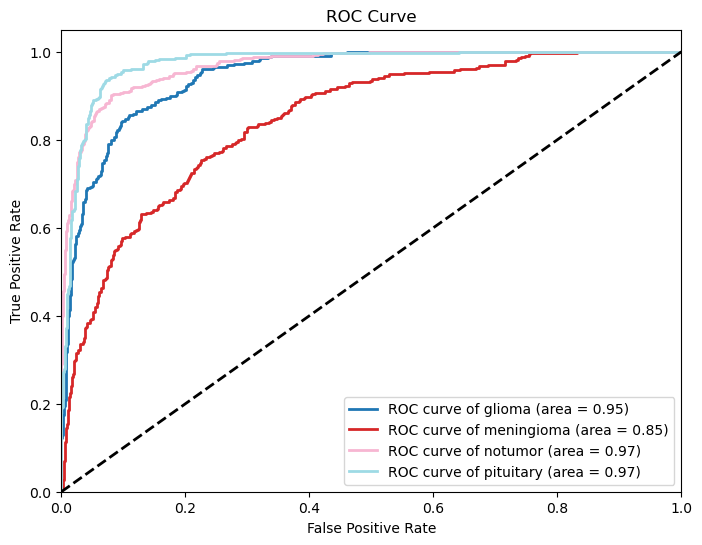

f1 score: 0.7550479046883359
Classification Report:
              precision    recall  f1-score   support

      glioma       0.63      0.88      0.74       325
  meningioma       0.66      0.46      0.54       333
     notumor       0.90      0.80      0.85       407
   pituitary       0.84      0.89      0.87       363

    accuracy                           0.76      1428
   macro avg       0.76      0.76      0.75      1428
weighted avg       0.77      0.76      0.76      1428



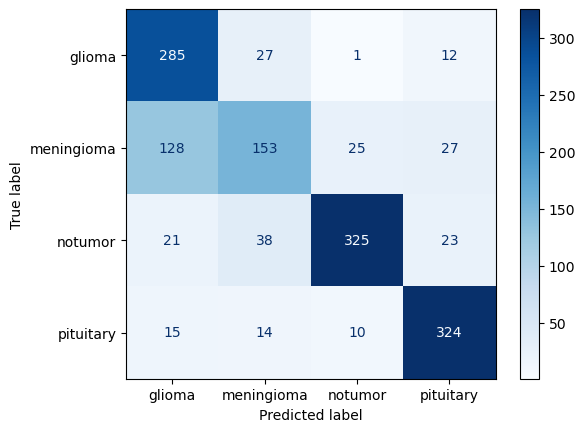

In [111]:
# plot the training curves 
plot_training_curves(history15)

# obtain prediction on validation data
val_y_pred = model.predict(val_data)

plot_roc_curve(val_y_pred, val_data)

get_evaluation_metrics(val_y_pred, val_data)

plot_confusion_matrix(val_y_pred, val_data)